## CMP Facade: Image Segmentation

Dataset Source: https://huggingface.co/datasets/Xpitfire/cmp_facade

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

import datasets
from datasets import load_dataset

import transformers
from transformers import Trainer, TrainingArguments
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation

import torchvision
from torchvision.transforms import ColorJitter

import evaluate

from PIL import Image

import peft
from peft import LoraConfig, get_peft_model

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python :".rjust(18), sys.version[0:6])
print("NumPy :".rjust(18), np.__version__)
print("Torch :".rjust(18), torch.__version__)
print("Torch Vision :".rjust(18), torchvision.__version__)
print("Transformers :".rjust(18), transformers.__version__)
print("Datasets :".rjust(18), datasets.__version__)
print("Evaluate :".rjust(18), evaluate.__version__)
print("PEFT :".rjust(18), peft.__version__)

          Python : 3.9.12
           NumPy : 1.25.1
           Torch : 2.0.1
    Torch Vision : 0.15.2
    Transformers : 4.26.1
        Datasets : 2.13.1
        Evaluate : 0.4.0
            PEFT : 0.3.0


#### Ingest Dataset

In [3]:
data = load_dataset("Xpitfire/cmp_facade")

data = data.rename_columns(
    {
        "pixel_values": "image",
        "label": "annotation",
    }
)

data

Found cached dataset parquet (/Users/briandunn/.cache/huggingface/datasets/Xpitfire___parquet/Xpitfire--cmp_facade-642b435710aeac91/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'annotation'],
        num_rows: 378
    })
    test: Dataset({
        features: ['image', 'annotation'],
        num_rows: 114
    })
    eval: Dataset({
        features: ['image', 'annotation'],
        num_rows: 114
    })
})

#### Display Sample

In [4]:
example = data['train'][12]

#### Display Above-Referenced Image

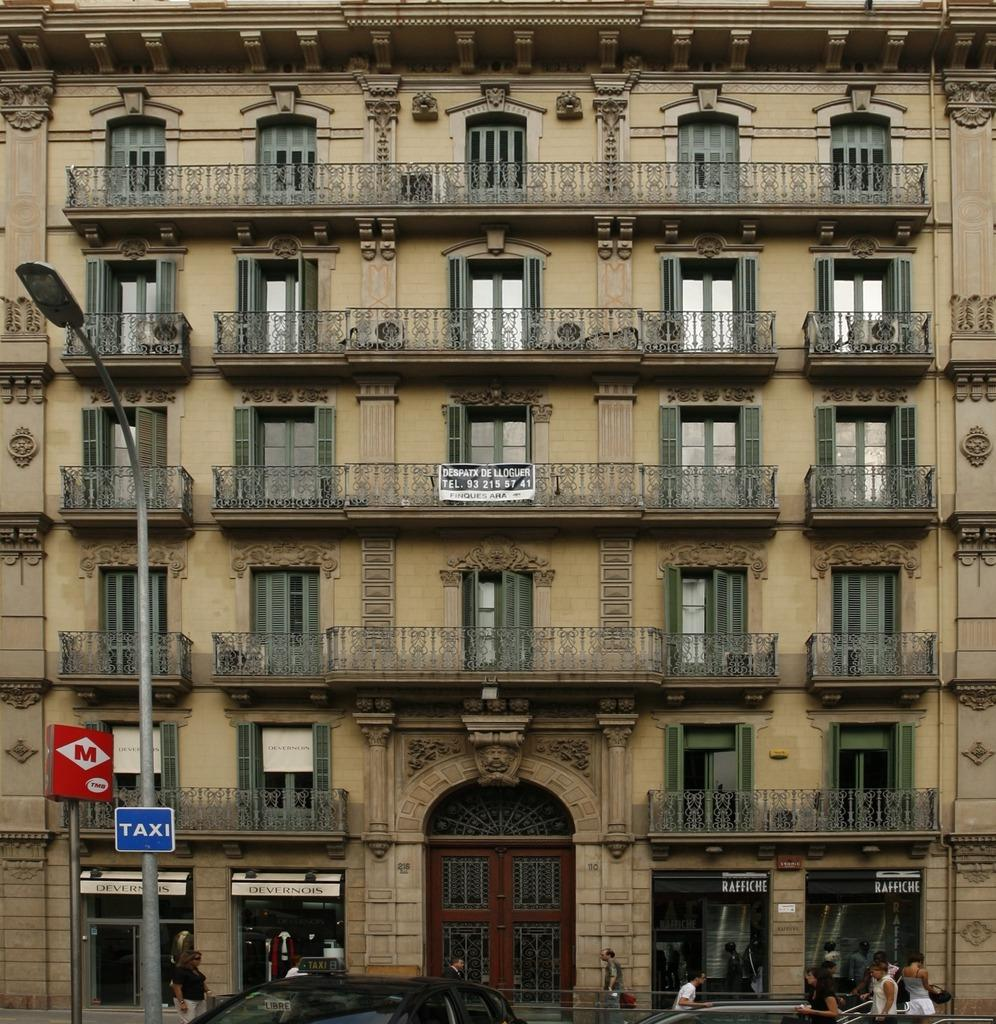

In [5]:
example['image']

#### Create Conversions Between String & Integer Values For Label Values

In [6]:
unique_colors = [[  0,   0,   0], 
                 [  0,   0, 170],
                 [  0,   0, 255], 
                 [  0,  85, 255], 
                 [  0, 170, 255], 
                 [  0, 255, 255], 
                 [ 85, 255, 170], 
                 [170,   0,   0], 
                 [170, 255,  85], 
                 [255,   0,   0], 
                 [255,  85,   0], 
                 [255, 170,   0], 
                 [255, 255,   0]]

id2label = {"0": "unknown", 
            "1": "background",
            "2": "facade", 
            "3": "window", 
            "4": "door", 
            "5": "cornice", 
            "6": "sill", 
            "7": "balcony", 
            "8": "blind",  
            "9": "molding",
            "10": "deco", 
            "11": "pillar",
            "12": "shop"}

label2id = {"unknown": 0,
            "background": 1,
            "facade": 2, 
            "window": 3, 
            "door": 4, 
            "cornice": 5, 
            "sill": 6, 
            "balcony": 7, 
            "blind": 8,  
            "molding": 9,
            "deco": 10, 
            "pillar": 11,
            "shop": 12}

unqiue_label_values = list(label2id.keys())

NUM_OF_LABELS = len(label2id.keys())

print(f"List of Unique Label Values: {unqiue_label_values}")
print(f"Number of Unique Label Values: {NUM_OF_LABELS}")
print(f"label2id dictionary values: {label2id}")
print(f"id2label dictionary values: {id2label}")

List of Unique Label Values: ['unknown', 'background', 'facade', 'window', 'door', 'cornice', 'sill', 'balcony', 'blind', 'molding', 'deco', 'pillar', 'shop']
Number of Unique Label Values: 13
label2id dictionary values: {'unknown': 0, 'background': 1, 'facade': 2, 'window': 3, 'door': 4, 'cornice': 5, 'sill': 6, 'balcony': 7, 'blind': 8, 'molding': 9, 'deco': 10, 'pillar': 11, 'shop': 12}
id2label dictionary values: {'0': 'unknown', '1': 'background', '2': 'facade', '3': 'window', '4': 'door', '5': 'cornice', '6': 'sill', '7': 'balcony', '8': 'blind', '9': 'molding', '10': 'deco', '11': 'pillar', '12': 'shop'}


#### Basic Values/Constants

In [7]:
MODEL_CKPT = "nvidia/mit-b0"
MODEL_NAME = f'{MODEL_CKPT.split("/")[-1]}-Image_segmentation-CMP_Facade'

LR = 5e-4
NUM_OF_EPOCHS = 100

STRATEGY = "epoch"
REPORTS_TO = "tensorboard"

#### Define Image Processor

In [8]:
image_processor = AutoImageProcessor.from_pretrained(MODEL_CKPT, reduce_labels=False)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


#### Augment Data (to Prevent Model Overfitting)

In [9]:
jitter = ColorJitter(brightness=0.30, 
                     contrast=0.30, 
                     saturation=0.30, 
                     hue=0.15)

#### Define Function to Convert Any Greyscale Images to RGB Images

In [10]:
def prepare_greyscale_images(image):
    np_image = np.array(image)
    if np_image.ndim == 2:
        tiled_image = np.tile(np.expand_dims(np_image, -1), 3)
        return Image.fromarray(tiled_image)
    else:
        return Image.fromarray(np_image)

#### Use Above Functions to Create Functions to Transform Training Dataset

In [11]:
def train_transform(sample_batch):
    images = [prepare_greyscale_images(x) for x in sample_batch["image"]]
    labels = [x for x in sample_batch['annotation']]
    inputs = image_processor(images, labels)
    return inputs

#### Use Above Functions to Create Function to Transform Testing Dataset

In [12]:
def test_transform(sample_batch):
    images = [jitter(prepare_greyscale_images(x)) for x in sample_batch["image"]]
    labels = [x for x in sample_batch['annotation']]
    inputs = image_processor(images, labels)
    return inputs

#### Apply Transformation Functions on Respective Datasets

In [13]:
train_ds = data['train']
test_ds = data['test']

train_ds.set_transform(train_transform)
test_ds.set_transform(test_transform)

#### Define Compute Metrics Function

In [14]:
metric = evaluate.load("mean_iou")
    
def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=NUM_OF_LABELS,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

#### Define Function to Display Number of Trainable Parameters

In [15]:
def print_trainable_parameters(model):
    """
    This function prints the following values:
    - the number of parameters
    - the trainable parameters 
    - the percentage of total parameters 
        that are trainable.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"| Trainable parameters: {trainable_params} |")
    print(f"| All parameters: {all_param} |")
    print(f"| % Trainable: {100 * trainable_params / all_param:.2f}")    

#### Define Base Model

In [16]:
model = AutoModelForSemanticSegmentation.from_pretrained(
    MODEL_CKPT, 
    id2label=id2label, 
    label2id=label2id,
    ignore_mismatched_sizes=True)

print_trainable_parameters(model)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.2

| Trainable parameters: 3717485 |
| All parameters: 3717485 |
| % Trainable: 100.00


#### Define LoRA Configuration

In [17]:
lora_config = LoraConfig(
    r=32, 
    lora_alpha=32,
    target_modules=['query', 'values'],
    lora_dropout=0.1,
    bias='lora_only',
    modules_to_save=['decode_head'],
)

#### Wrap Base Model With LoRA Configuration

In [18]:
lora_model = get_peft_model(model, 
                            lora_config)

print_trainable_parameters(lora_model)

| Trainable parameters: 862746 |
| All parameters: 4181114 |
| % Trainable: 20.63


#### Define Training Arguments

In [19]:
args = TrainingArguments(
    MODEL_NAME,
    learning_rate=LR,
    remove_unused_columns=False,
    num_train_epochs=NUM_OF_EPOCHS,
    auto_find_batch_size=True,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    label_names=['labels'],
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=24,
    report_to=REPORTS_TO,
    load_best_model_at_end=True,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Trainer

In [20]:
trainer = Trainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/DunnBC22/mit-b0-Image_segmentation-CMP_Facade into local empty directory.


#### Train Model

In [21]:
trainer.train()

/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 378
  Num Epochs = 100
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4800
  Number of trainable parameters = 862746


  0%|          | 0/4800 [00:00<?, ?it/s]

{'loss': 2.5264, 'learning_rate': 0.0004998958333333333, 'epoch': 0.02}
{'loss': 1.7252, 'learning_rate': 0.0004975, 'epoch': 0.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 1.2617, 'learning_rate': 0.000495, 'epoch': 1.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5045279762954943, 0.46623430219058126, 0.5055248810406884, 0.0, 0.23332564005476739, 0.03251302005198546, 0.28980345593113455, 0.0, 0.00016251146090116996, 0.35684244137718846, 0.0, 0.3088651292132138]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a

{'eval_loss': 1.238174557685852, 'eval_mean_iou': 0.22481661313466292, 'eval_mean_accuracy': 0.32313559899877226, 'eval_overall_accuracy': 0.5890259993703741, 'eval_per_category_iou': [nan, 0.5045279762954943, 0.46623430219058126, 0.5055248810406884, 0.0, 0.23332564005476739, 0.03251302005198546, 0.28980345593113455, 0.0, 0.00016251146090116996, 0.35684244137718846, 0.0, 0.3088651292132138], 'eval_per_category_accuracy': [nan, 0.6437900021784007, 0.7306961272509425, 0.6865631136884549, 0.0, 0.33413944187961303, 0.03301063959416907, 0.448126112981499, 0.0, 0.00016258572826871465, 0.5707513170099501, 0.0, 0.43038784767396887], 'eval_runtime': 31.6974, 'eval_samples_per_second': 3.597, 'eval_steps_per_second': 0.473, 'epoch': 1.0}
{'loss': 1.1042, 'learning_rate': 0.0004925, 'epoch': 1.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 1.044, 'learning_rate': 0.00049, 'epoch': 2.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5318323315790788, 0.477710449608753, 0.5146417667244276, 0.10088874090769388, 0.29335135831528514, 0.24050753672963174, 0.32090307587297157, 0.02477297922655908, 0.09684152655522194, 0.36733300452214424, 0.0005099321178364736, 0.35381055360802527]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped 

{'eval_loss': 1.1343224048614502, 'eval_mean_iou': 0.2769252713139691, 'eval_mean_accuracy': 0.37790925730274955, 'eval_overall_accuracy': 0.6105794739304927, 'eval_per_category_iou': [nan, 0.5318323315790788, 0.477710449608753, 0.5146417667244276, 0.10088874090769388, 0.29335135831528514, 0.24050753672963174, 0.32090307587297157, 0.02477297922655908, 0.09684152655522194, 0.36733300452214424, 0.0005099321178364736, 0.35381055360802527], 'eval_per_category_accuracy': [nan, 0.69232137605391, 0.7402076002899532, 0.6415460740045598, 0.10696141177876195, 0.39638309759755347, 0.3314403534987526, 0.48528485529541304, 0.024947491059288472, 0.1056554566736498, 0.5112624562323446, 0.0005102075524323295, 0.4983907075963759], 'eval_runtime': 31.5484, 'eval_samples_per_second': 3.613, 'eval_steps_per_second': 0.475, 'epoch': 2.0}
{'loss': 0.9803, 'learning_rate': 0.0004875, 'epoch': 2.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.9958, 'learning_rate': 0.00048499999999999997, 'epoch': 3.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5260114182781279, 0.48500959546271993, 0.5346549760869227, 0.1749235641969206, 0.3053781108517997, 0.24975038315420134, 0.31143712690572206, 0.06671918619406142, 0.10404573563046837, 0.3903113471429269, 0.009821729974762494, 0.36685396464396913]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped th

{'eval_loss': 1.1237345933914185, 'eval_mean_iou': 0.29374309487688355, 'eval_mean_accuracy': 0.4134870263357285, 'eval_overall_accuracy': 0.6153021695321066, 'eval_per_category_iou': [nan, 0.5260114182781279, 0.48500959546271993, 0.5346549760869227, 0.1749235641969206, 0.3053781108517997, 0.24975038315420134, 0.31143712690572206, 0.06671918619406142, 0.10404573563046837, 0.3903113471429269, 0.009821729974762494, 0.36685396464396913], 'eval_per_category_accuracy': [nan, 0.6673956505441656, 0.7164308325449039, 0.6996144114334547, 0.20755254933160996, 0.4227894257064722, 0.3268500644532377, 0.5403627696643724, 0.06822242706190514, 0.11334092799100066, 0.5714468851820408, 0.009975578065156906, 0.6178627940504238], 'eval_runtime': 31.672, 'eval_samples_per_second': 3.599, 'eval_steps_per_second': 0.474, 'epoch': 3.0}
{'loss': 0.9437, 'learning_rate': 0.0004825, 'epoch': 3.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.9392, 'learning_rate': 0.00048, 'epoch': 4.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5481547747632213, 0.4822825277575903, 0.553420231560001, 0.23162128673004612, 0.3225713332376761, 0.2575979110983993, 0.32068811195230895, 0.08126849982742211, 0.1431445711546185, 0.4002423524191714, 0.010295572594607965, 0.39112286172039457]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.0863579511642456, 'eval_mean_iou': 0.3118675029012881, 'eval_mean_accuracy': 0.43633415549274285, 'eval_overall_accuracy': 0.6248809078283477, 'eval_per_category_iou': [nan, 0.5481547747632213, 0.4822825277575903, 0.553420231560001, 0.23162128673004612, 0.3225713332376761, 0.2575979110983993, 0.32068811195230895, 0.08126849982742211, 0.1431445711546185, 0.4002423524191714, 0.010295572594607965, 0.39112286172039457], 'eval_per_category_accuracy': [nan, 0.7405808003000978, 0.6725991468307989, 0.7204276240414228, 0.2928724071544751, 0.4468844649630958, 0.33501093460401343, 0.6078245148193628, 0.08401430513844249, 0.1617068864942892, 0.5893865063909978, 0.010420479050877897, 0.5742817961250396], 'eval_runtime': 31.5798, 'eval_samples_per_second': 3.61, 'eval_steps_per_second': 0.475, 'epoch': 4.0}
{'loss': 0.9118, 'learning_rate': 0.0004775, 'epoch': 4.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.9036, 'learning_rate': 0.000475, 'epoch': 5.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5597403605771192, 0.48347725839792266, 0.5509163756679119, 0.2369532434325883, 0.3270982329909121, 0.2807115847181017, 0.3314917072917315, 0.1000208485353904, 0.1725076871781573, 0.4014876549688917, 0.047097888030475106, 0.3845829517090154]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0751112699508667, 'eval_mean_iou': 0.3230071494581848, 'eval_mean_accuracy': 0.46299591268471807, 'eval_overall_accuracy': 0.6275343309369004, 'eval_per_category_iou': [nan, 0.5597403605771192, 0.48347725839792266, 0.5509163756679119, 0.2369532434325883, 0.3270982329909121, 0.2807115847181017, 0.3314917072917315, 0.1000208485353904, 0.1725076871781573, 0.4014876549688917, 0.047097888030475106, 0.3845829517090154], 'eval_per_category_accuracy': [nan, 0.7407425682754777, 0.6570052116940664, 0.7352382000113051, 0.325117507935689, 0.5325832916752433, 0.4088403547814041, 0.6129638272516776, 0.10374739482668671, 0.21484715293714413, 0.5726229826145175, 0.05032959407887128, 0.6019128661345335], 'eval_runtime': 31.598, 'eval_samples_per_second': 3.608, 'eval_steps_per_second': 0.475, 'epoch': 5.0}
{'loss': 0.8905, 'learning_rate': 0.0004725, 'epoch': 5.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.8787, 'learning_rate': 0.00047, 'epoch': 6.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5702964872864719, 0.4957770854699997, 0.5533829534674145, 0.22257625957069016, 0.3238334384389298, 0.29042553518905895, 0.32844699130642097, 0.1395754523769366, 0.18364345407619856, 0.39774799067534183, 0.021688575326965956, 0.40466660086483186]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped th

{'eval_loss': 1.05884850025177, 'eval_mean_iou': 0.32767173533743843, 'eval_mean_accuracy': 0.4543241824971682, 'eval_overall_accuracy': 0.6363617746453536, 'eval_per_category_iou': [nan, 0.5702964872864719, 0.4957770854699997, 0.5533829534674145, 0.22257625957069016, 0.3238334384389298, 0.29042553518905895, 0.32844699130642097, 0.1395754523769366, 0.18364345407619856, 0.39774799067534183, 0.021688575326965956, 0.40466660086483186], 'eval_per_category_accuracy': [nan, 0.7366352877913961, 0.6866123044501439, 0.7789314504487694, 0.27161915209640675, 0.4306513364895463, 0.45388547204781726, 0.5243593984349157, 0.15658882458364531, 0.2416924734891886, 0.5672896040678745, 0.022167497738079852, 0.5814573883282347], 'eval_runtime': 31.5575, 'eval_samples_per_second': 3.612, 'eval_steps_per_second': 0.475, 'epoch': 6.0}
{'loss': 0.87, 'learning_rate': 0.00046750000000000003, 'epoch': 6.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.8702, 'learning_rate': 0.000465, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5749571265270055, 0.5055998391910677, 0.5598972717045693, 0.25350569857204386, 0.3340856691756217, 0.29356907677389216, 0.32176530987196494, 0.0980261595796298, 0.16741449496601607, 0.39193859458751173, 0.038767688486230904, 0.39082039853215456]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped th

{'eval_loss': 1.040664553642273, 'eval_mean_iou': 0.327528943997309, 'eval_mean_accuracy': 0.4522198816159317, 'eval_overall_accuracy': 0.6407453971996642, 'eval_per_category_iou': [nan, 0.5749571265270055, 0.5055998391910677, 0.5598972717045693, 0.25350569857204386, 0.3340856691756217, 0.29356907677389216, 0.32176530987196494, 0.0980261595796298, 0.16741449496601607, 0.39193859458751173, 0.038767688486230904, 0.39082039853215456], 'eval_per_category_accuracy': [nan, 0.7340519064930637, 0.7164107043281633, 0.7458163579749792, 0.33243001794864135, 0.4855847325550622, 0.5057767416804018, 0.44757149136122454, 0.10267153596423174, 0.2024005563068432, 0.5541515536354602, 0.040281906679637276, 0.5594910744634716], 'eval_runtime': 31.542, 'eval_samples_per_second': 3.614, 'eval_steps_per_second': 0.476, 'epoch': 7.0}
{'loss': 0.8637, 'learning_rate': 0.0004625, 'epoch': 7.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.8394, 'learning_rate': 0.00046, 'epoch': 8.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.569877722827078, 0.5099985242453808, 0.5434809870289127, 0.23887582253197173, 0.33699438412359917, 0.2837798652570335, 0.3379458390278118, 0.06871607482393431, 0.18516713552799974, 0.386165216187914, 0.045365283173597025, 0.3933042865274891]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.046876072883606, 'eval_mean_iou': 0.32497259510689347, 'eval_mean_accuracy': 0.4467838201547001, 'eval_overall_accuracy': 0.6386115090888843, 'eval_per_category_iou': [nan, 0.569877722827078, 0.5099985242453808, 0.5434809870289127, 0.23887582253197173, 0.33699438412359917, 0.2837798652570335, 0.3379458390278118, 0.06871607482393431, 0.18516713552799974, 0.386165216187914, 0.045365283173597025, 0.3933042865274891], 'eval_per_category_accuracy': [nan, 0.6956765896507185, 0.7525415658808557, 0.6782869996967076, 0.30005729445275653, 0.5405204810774252, 0.38913241452731084, 0.5846572809946939, 0.06994704503739826, 0.23666549853947483, 0.5088866897943773, 0.047868352845937726, 0.5571656293587445], 'eval_runtime': 31.5122, 'eval_samples_per_second': 3.618, 'eval_steps_per_second': 0.476, 'epoch': 8.0}
{'loss': 0.8335, 'learning_rate': 0.0004575, 'epoch': 8.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.843, 'learning_rate': 0.000455, 'epoch': 9.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5691258552445416, 0.5071816837630009, 0.5620202943753352, 0.25302301896237733, 0.3335045497066077, 0.3015661963037572, 0.3437212684192728, 0.13350123034622982, 0.1479328566097913, 0.4051659874689668, 0.09069845906288562, 0.40514120734565445]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0421428680419922, 'eval_mean_iou': 0.3377152173007018, 'eval_mean_accuracy': 0.473387080287796, 'eval_overall_accuracy': 0.6405008215653268, 'eval_per_category_iou': [nan, 0.5691258552445416, 0.5071816837630009, 0.5620202943753352, 0.25302301896237733, 0.3335045497066077, 0.3015661963037572, 0.3437212684192728, 0.13350123034622982, 0.1479328566097913, 0.4051659874689668, 0.09069845906288562, 0.40514120734565445], 'eval_per_category_accuracy': [nan, 0.7076718111873349, 0.7162999991360898, 0.7158338687041756, 0.3184105269731965, 0.5765989355132767, 0.4956389849096051, 0.5766361111236978, 0.15618875646393846, 0.170287677869336, 0.560560540276995, 0.10460207212293961, 0.5819156791729667], 'eval_runtime': 31.599, 'eval_samples_per_second': 3.608, 'eval_steps_per_second': 0.475, 'epoch': 9.0}
{'loss': 0.8077, 'learning_rate': 0.00045250000000000005, 'epoch': 9.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.8531, 'learning_rate': 0.00045000000000000004, 'epoch': 10.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5833017483438467, 0.5075777416016664, 0.5531036654123048, 0.2580443072834985, 0.33191025547021297, 0.3018390495547636, 0.3493495264779257, 0.13390375667488993, 0.2137113453991504, 0.3977426767699396, 0.08739018830536852, 0.3950844940262889]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0384883880615234, 'eval_mean_iou': 0.34274656294332134, 'eval_mean_accuracy': 0.46554723187706254, 'eval_overall_accuracy': 0.6439582757782518, 'eval_per_category_iou': [nan, 0.5833017483438467, 0.5075777416016664, 0.5531036654123048, 0.2580443072834985, 0.33191025547021297, 0.3018390495547636, 0.3493495264779257, 0.13390375667488993, 0.2137113453991504, 0.3977426767699396, 0.08739018830536852, 0.3950844940262889], 'eval_per_category_accuracy': [nan, 0.7397509333900035, 0.7279168302084277, 0.6684072043795665, 0.3333016539360746, 0.4738706736848296, 0.4247740930050601, 0.581479987856324, 0.150685116654998, 0.30761329643662616, 0.5323118709336452, 0.10176531813141586, 0.5446898039077792], 'eval_runtime': 31.7584, 'eval_samples_per_second': 3.59, 'eval_steps_per_second': 0.472, 'epoch': 10.0}
{'loss': 0.8104, 'learning_rate': 0.00044750000000000004, 'epoch': 10.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.824, 'learning_rate': 0.00044500000000000003, 'epoch': 11.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5883926569248009, 0.5091522758029811, 0.5735515255694027, 0.2582175299886701, 0.3295453231137426, 0.3067148751300274, 0.3443950170783129, 0.0995653624064539, 0.19996133234846494, 0.41236425519227365, 0.09872432911339835, 0.3974226311505393]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0188692808151245, 'eval_mean_iou': 0.34316725948492227, 'eval_mean_accuracy': 0.4629612959196214, 'eval_overall_accuracy': 0.6504472096761068, 'eval_per_category_iou': [nan, 0.5883926569248009, 0.5091522758029811, 0.5735515255694027, 0.2582175299886701, 0.3295453231137426, 0.3067148751300274, 0.3443950170783129, 0.0995653624064539, 0.19996133234846494, 0.41236425519227365, 0.09872432911339835, 0.3974226311505393], 'eval_per_category_accuracy': [nan, 0.7639575343644803, 0.7073174706954094, 0.7605032465657758, 0.3149972981999766, 0.43567971300026465, 0.4500551540143785, 0.504663987203828, 0.103287857121618, 0.2658672135991976, 0.5673636270778651, 0.11643344512547704, 0.5654090040671848], 'eval_runtime': 31.626, 'eval_samples_per_second': 3.605, 'eval_steps_per_second': 0.474, 'epoch': 11.0}
{'loss': 0.7987, 'learning_rate': 0.0004425, 'epoch': 11.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.8185, 'learning_rate': 0.00044, 'epoch': 12.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5994731238503548, 0.5023281839793163, 0.5659298238046971, 0.2580119227053475, 0.34258568998957617, 0.3033939635949229, 0.3487804827221159, 0.1100009184467615, 0.19489525586716974, 0.41845187710187365, 0.11253181438882431, 0.400330422170078]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0199121236801147, 'eval_mean_iou': 0.3463927898850865, 'eval_mean_accuracy': 0.4860681946444343, 'eval_overall_accuracy': 0.6472347661068565, 'eval_per_category_iou': [nan, 0.5994731238503548, 0.5023281839793163, 0.5659298238046971, 0.2580119227053475, 0.34258568998957617, 0.3033939635949229, 0.3487804827221159, 0.1100009184467615, 0.19489525586716974, 0.41845187710187365, 0.11253181438882431, 0.400330422170078], 'eval_per_category_accuracy': [nan, 0.7779224281905789, 0.6738538650495693, 0.717734460519414, 0.4039286073103377, 0.49945481812568, 0.43366928113796843, 0.606699865422695, 0.1230263531358042, 0.251500347691777, 0.6051178433912959, 0.14659963673222268, 0.5933108290258682], 'eval_runtime': 31.7377, 'eval_samples_per_second': 3.592, 'eval_steps_per_second': 0.473, 'epoch': 12.0}
{'loss': 0.7989, 'learning_rate': 0.0004375, 'epoch': 12.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.8017, 'learning_rate': 0.000435, 'epoch': 13.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5946404315387922, 0.5121154637272631, 0.5632446218211189, 0.2680685447625605, 0.33344791811007957, 0.3103760501439731, 0.34352331779445217, 0.101018283100589, 0.179111521530267, 0.4067505556577313, 0.1202758322959759, 0.402074456040676]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attrib

{'eval_loss': 1.0252286195755005, 'eval_mean_iou': 0.3445539163769566, 'eval_mean_accuracy': 0.4740113544152937, 'eval_overall_accuracy': 0.64898681640625, 'eval_per_category_iou': [nan, 0.5946404315387922, 0.5121154637272631, 0.5632446218211189, 0.2680685447625605, 0.33344791811007957, 0.3103760501439731, 0.34352331779445217, 0.101018283100589, 0.179111521530267, 0.4067505556577313, 0.1202758322959759, 0.402074456040676], 'eval_per_category_accuracy': [nan, 0.7564681256811007, 0.7078033088472686, 0.7139782541176957, 0.3806008042946401, 0.441552621519099, 0.5034262828118287, 0.5586997204235786, 0.10686414173224089, 0.22138573573886974, 0.59173291174679, 0.15617113041585318, 0.5494532156545588], 'eval_runtime': 31.8946, 'eval_samples_per_second': 3.574, 'eval_steps_per_second': 0.47, 'epoch': 13.0}
{'loss': 0.7855, 'learning_rate': 0.0004325, 'epoch': 13.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.7792, 'learning_rate': 0.00043, 'epoch': 14.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5770450543836535, 0.5133663219472165, 0.5666719179007067, 0.2519970276797325, 0.33417180025349924, 0.2972872423539266, 0.34364357504302084, 0.12604508864759134, 0.171523562063416, 0.41776503323718256, 0.10540738074927135, 0.3957916211784641]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0361591577529907, 'eval_mean_iou': 0.34172630211980676, 'eval_mean_accuracy': 0.4713664262080019, 'eval_overall_accuracy': 0.6450673153525904, 'eval_per_category_iou': [nan, 0.5770450543836535, 0.5133663219472165, 0.5666719179007067, 0.2519970276797325, 0.33417180025349924, 0.2972872423539266, 0.34364357504302084, 0.12604508864759134, 0.171523562063416, 0.41776503323718256, 0.10540738074927135, 0.3957916211784641], 'eval_per_category_accuracy': [nan, 0.697948069956659, 0.7274415905423743, 0.7039890547306016, 0.30203951959551745, 0.46144264416149616, 0.4484165667267375, 0.682088531023014, 0.13586908041098888, 0.2080559031252712, 0.6097047887925028, 0.12911244294178872, 0.5502889224890701], 'eval_runtime': 31.9386, 'eval_samples_per_second': 3.569, 'eval_steps_per_second': 0.47, 'epoch': 14.0}
{'loss': 0.7828, 'learning_rate': 0.0004275, 'epoch': 14.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.7986, 'learning_rate': 0.000425, 'epoch': 15.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5891616883116152, 0.5162044782885433, 0.5683047118152451, 0.24090268657754893, 0.3336086270619098, 0.29183298443805816, 0.35629157949650153, 0.15014591003479305, 0.19936222884236143, 0.41322371456484686, 0.08718620332852703, 0.40098461604087765]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped th

{'eval_loss': 1.0219142436981201, 'eval_mean_iou': 0.3456007857334023, 'eval_mean_accuracy': 0.47417705732520243, 'eval_overall_accuracy': 0.6508802782025254, 'eval_per_category_iou': [nan, 0.5891616883116152, 0.5162044782885433, 0.5683047118152451, 0.24090268657754893, 0.3336086270619098, 0.29183298443805816, 0.35629157949650153, 0.15014591003479305, 0.19936222884236143, 0.41322371456484686, 0.08718620332852703, 0.40098461604087765], 'eval_per_category_accuracy': [nan, 0.7330243854709368, 0.7188422997859195, 0.7460783199424778, 0.3008501845098609, 0.4390190254947511, 0.4244550334451378, 0.60037337272476, 0.17649491670203304, 0.260983050437828, 0.5707389109188902, 0.10225919904217036, 0.6170059894276639], 'eval_runtime': 31.871, 'eval_samples_per_second': 3.577, 'eval_steps_per_second': 0.471, 'epoch': 15.0}
{'loss': 0.76, 'learning_rate': 0.00042249999999999997, 'epoch': 15.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.799, 'learning_rate': 0.00042, 'epoch': 16.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5791799215052411, 0.509480607841737, 0.5530740767361692, 0.23530724882633386, 0.3421823377887392, 0.30327879261192275, 0.34123473186472714, 0.15544112925283324, 0.1804083867574423, 0.3927411830804219, 0.11899467518636847, 0.3981401900927901]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0453834533691406, 'eval_mean_iou': 0.3424552734620605, 'eval_mean_accuracy': 0.48781548271328173, 'eval_overall_accuracy': 0.640545359829016, 'eval_per_category_iou': [nan, 0.5791799215052411, 0.509480607841737, 0.5530740767361692, 0.23530724882633386, 0.3421823377887392, 0.30327879261192275, 0.34123473186472714, 0.15544112925283324, 0.1804083867574423, 0.3927411830804219, 0.11899467518636847, 0.3981401900927901], 'eval_per_category_accuracy': [nan, 0.7088477830638181, 0.7039980961913228, 0.7202407254219199, 0.2805038653390284, 0.5839033140235834, 0.45949867566232916, 0.7022597206048276, 0.17666791913217655, 0.22947657282467437, 0.5076158925334768, 0.15202280287621003, 0.6287504248860133], 'eval_runtime': 31.855, 'eval_samples_per_second': 3.579, 'eval_steps_per_second': 0.471, 'epoch': 16.0}
{'loss': 0.7403, 'learning_rate': 0.0004175, 'epoch': 16.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.7818, 'learning_rate': 0.000415, 'epoch': 17.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6095299058293333, 0.512222668950992, 0.5712112837614388, 0.247230826099703, 0.34045125724942105, 0.2936451380169054, 0.36813136278146313, 0.08452465487354065, 0.15279682236861716, 0.4059346947544888, 0.10778231436802942, 0.3963218540017404]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0047920942306519, 'eval_mean_iou': 0.3408152319213061, 'eval_mean_accuracy': 0.4673487217086552, 'eval_overall_accuracy': 0.6544407961661356, 'eval_per_category_iou': [nan, 0.6095299058293333, 0.512222668950992, 0.5712112837614388, 0.247230826099703, 0.34045125724942105, 0.2936451380169054, 0.36813136278146313, 0.08452465487354065, 0.15279682236861716, 0.4059346947544888, 0.10778231436802942, 0.3963218540017404], 'eval_per_category_accuracy': [nan, 0.7923546828744907, 0.6985022914549752, 0.7506240590490234, 0.3160047030328045, 0.44943570441379715, 0.42481577917871827, 0.6057600898994522, 0.08752030751181958, 0.18019332321932924, 0.5547449783244912, 0.13274648126858005, 0.615482260276381], 'eval_runtime': 31.8567, 'eval_samples_per_second': 3.579, 'eval_steps_per_second': 0.471, 'epoch': 17.0}
{'loss': 0.76, 'learning_rate': 0.0004125, 'epoch': 17.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.7535, 'learning_rate': 0.00041, 'epoch': 18.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5933223738547421, 0.5141315738089878, 0.5611215193437239, 0.23082878605755258, 0.3351178584980386, 0.300587074024473, 0.34268095645676117, 0.12671141748294232, 0.18350043908146416, 0.413283478570715, 0.08946503667252599, 0.39275981636853896]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0314524173736572, 'eval_mean_iou': 0.34029252751837213, 'eval_mean_accuracy': 0.4698061503920677, 'eval_overall_accuracy': 0.6484841463858622, 'eval_per_category_iou': [nan, 0.5933223738547421, 0.5141315738089878, 0.5611215193437239, 0.23082878605755258, 0.3351178584980386, 0.300587074024473, 0.34268095645676117, 0.12671141748294232, 0.18350043908146416, 0.413283478570715, 0.08946503667252599, 0.39275981636853896], 'eval_per_category_accuracy': [nan, 0.7351262477091047, 0.7110341548228588, 0.7219732604297027, 0.26958805016930376, 0.4394142382450672, 0.4098809058084873, 0.6686942376444893, 0.13644485412381027, 0.2320779444769738, 0.600513942998974, 0.10393948258151416, 0.6089864856945275], 'eval_runtime': 31.9287, 'eval_samples_per_second': 3.57, 'eval_steps_per_second': 0.47, 'epoch': 18.0}
{'loss': 0.7488, 'learning_rate': 0.0004075, 'epoch': 18.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.7479, 'learning_rate': 0.00040500000000000003, 'epoch': 19.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5989171154495188, 0.5090862884217086, 0.5773567693773612, 0.2320218050931505, 0.3459892102237552, 0.3155849516800912, 0.3383478607141277, 0.12224314314637987, 0.19530996307677606, 0.40905420574124646, 0.09696717703449309, 0.41600989317350057]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.0474207401275635, 'eval_mean_iou': 0.3464073652610091, 'eval_mean_accuracy': 0.47912261617102064, 'eval_overall_accuracy': 0.651209647195381, 'eval_per_category_iou': [nan, 0.5989171154495188, 0.5090862884217086, 0.5773567693773612, 0.2320218050931505, 0.3459892102237552, 0.3155849516800912, 0.3383478607141277, 0.12224314314637987, 0.19530996307677606, 0.40905420574124646, 0.09696717703449309, 0.41600989317350057], 'eval_per_category_accuracy': [nan, 0.7664332572528546, 0.6945525297027018, 0.7343562816474065, 0.2776092735552158, 0.460152321580851, 0.48294554503068743, 0.616774585279871, 0.13285235053536143, 0.24249002239947973, 0.576729812291707, 0.11359260947353383, 0.6509828053025775], 'eval_runtime': 31.8566, 'eval_samples_per_second': 3.579, 'eval_steps_per_second': 0.471, 'epoch': 19.0}
{'loss': 0.7286, 'learning_rate': 0.0004025, 'epoch': 19.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.7594, 'learning_rate': 0.0004, 'epoch': 20.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5943700465392034, 0.5066825193989583, 0.5724643772479401, 0.24237657529499734, 0.34487111168072526, 0.30810086307324225, 0.3564618494058883, 0.11703034887474524, 0.19960597809892094, 0.42300853262692356, 0.09860872884122816, 0.40571818969244366]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped th

{'eval_loss': 1.0219690799713135, 'eval_mean_iou': 0.34744159339793473, 'eval_mean_accuracy': 0.4869643615901808, 'eval_overall_accuracy': 0.6501567572878119, 'eval_per_category_iou': [nan, 0.5943700465392034, 0.5066825193989583, 0.5724643772479401, 0.24237657529499734, 0.34487111168072526, 0.30810086307324225, 0.3564618494058883, 0.11703034887474524, 0.19960597809892094, 0.42300853262692356, 0.09860872884122816, 0.40571818969244366], 'eval_per_category_accuracy': [nan, 0.7549496935239822, 0.6745337712734544, 0.7781741311645395, 0.2886934420932297, 0.4810927162054871, 0.47322144336772975, 0.6273386771549361, 0.13131965713080876, 0.25755337041313253, 0.6154471548077531, 0.11670147415968816, 0.644546807787428], 'eval_runtime': 31.9319, 'eval_samples_per_second': 3.57, 'eval_steps_per_second': 0.47, 'epoch': 20.0}
{'loss': 0.7273, 'learning_rate': 0.0003975, 'epoch': 20.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.7633, 'learning_rate': 0.000395, 'epoch': 21.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5789895603867098, 0.5203205990874893, 0.5784893957601429, 0.2426319021095566, 0.3505679520197736, 0.31751139353992514, 0.3572101486232127, 0.1177523227695049, 0.17276023855994171, 0.4196470788939767, 0.14147600222664616, 0.4051026359032569]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0244594812393188, 'eval_mean_iou': 0.3502049358233447, 'eval_mean_accuracy': 0.47849943914291027, 'eval_overall_accuracy': 0.6520709991455078, 'eval_per_category_iou': [nan, 0.5789895603867098, 0.5203205990874893, 0.5784893957601429, 0.2426319021095566, 0.3505679520197736, 0.31751139353992514, 0.3572101486232127, 0.1177523227695049, 0.17276023855994171, 0.4196470788939767, 0.14147600222664616, 0.4051026359032569], 'eval_per_category_accuracy': [nan, 0.6868469178714923, 0.741624234871708, 0.7648353438357188, 0.30044287797367714, 0.5128285353015556, 0.4905933545825931, 0.5109660113008686, 0.1250456158751355, 0.2094521629943897, 0.587962700673692, 0.204013632745801, 0.6073818816882919], 'eval_runtime': 31.9479, 'eval_samples_per_second': 3.568, 'eval_steps_per_second': 0.47, 'epoch': 21.0}
{'loss': 0.7276, 'learning_rate': 0.0003925, 'epoch': 21.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.7378, 'learning_rate': 0.00039000000000000005, 'epoch': 22.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6106080770588961, 0.5091303815647046, 0.5728651790504228, 0.2774731214089121, 0.3525616006293052, 0.31713350365019505, 0.3593730024681034, 0.11388875287665867, 0.1657850107774964, 0.41597905632500715, 0.14174761049330203, 0.4120335673018426]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0186225175857544, 'eval_mean_iou': 0.35404823863373713, 'eval_mean_accuracy': 0.4913561366045934, 'eval_overall_accuracy': 0.6542595645837617, 'eval_per_category_iou': [nan, 0.6106080770588961, 0.5091303815647046, 0.5728651790504228, 0.2774731214089121, 0.3525616006293052, 0.31713350365019505, 0.3593730024681034, 0.11388875287665867, 0.1657850107774964, 0.41597905632500715, 0.14174761049330203, 0.4120335673018426], 'eval_per_category_accuracy': [nan, 0.7819507872100687, 0.6864607193842476, 0.7295102891488788, 0.36244579428847623, 0.550371394124739, 0.46393183989944015, 0.6496168851471061, 0.12574843824759352, 0.19813487804422553, 0.5773815456087193, 0.18883937985972693, 0.5818816882918996], 'eval_runtime': 31.9412, 'eval_samples_per_second': 3.569, 'eval_steps_per_second': 0.47, 'epoch': 22.0}
{'loss': 0.7375, 'learning_rate': 0.00038750000000000004, 'epoch': 22.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.7166, 'learning_rate': 0.00038500000000000003, 'epoch': 23.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5912342675687187, 0.5136939496304719, 0.5761188635123845, 0.2383527553779522, 0.3323276996281982, 0.30106328721531433, 0.35184028963995273, 0.1153344471802087, 0.1643503915683763, 0.4172058385781472, 0.133159503052273, 0.38872060486675625]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.0337165594100952, 'eval_mean_iou': 0.3436168248182296, 'eval_mean_accuracy': 0.47911857005785685, 'eval_overall_accuracy': 0.6491545292369106, 'eval_per_category_iou': [nan, 0.5912342675687187, 0.5136939496304719, 0.5761188635123845, 0.2383527553779522, 0.3323276996281982, 0.30106328721531433, 0.35184028963995273, 0.1153344471802087, 0.1643503915683763, 0.4172058385781472, 0.133159503052273, 0.38872060486675625], 'eval_per_category_accuracy': [nan, 0.7219214110428932, 0.7185157061098667, 0.7343413905378852, 0.32457443255411067, 0.44713853030258477, 0.46091440225233604, 0.5683965363336068, 0.12763524600134618, 0.19833701165234338, 0.5813423969477708, 0.17981891033272335, 0.6864868666268152], 'eval_runtime': 31.8357, 'eval_samples_per_second': 3.581, 'eval_steps_per_second': 0.471, 'epoch': 23.0}
{'loss': 0.6903, 'learning_rate': 0.00038250000000000003, 'epoch': 23.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.7406, 'learning_rate': 0.00038, 'epoch': 24.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5855813584881481, 0.5130629794735074, 0.5701877445007375, 0.22590799654954874, 0.3464990667168098, 0.32377170215446643, 0.3602631853522457, 0.15988936414753627, 0.19879277661378827, 0.4103204919456551, 0.11980221599989316, 0.3811211068659555]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.0227550268173218, 'eval_mean_iou': 0.3495999990673577, 'eval_mean_accuracy': 0.4895177493493012, 'eval_overall_accuracy': 0.6489512460273609, 'eval_per_category_iou': [nan, 0.5855813584881481, 0.5130629794735074, 0.5701877445007375, 0.22590799654954874, 0.3464990667168098, 0.32377170215446643, 0.3602631853522457, 0.15988936414753627, 0.19879277661378827, 0.4103204919456551, 0.11980221599989316, 0.3811211068659555], 'eval_per_category_accuracy': [nan, 0.7302325561835318, 0.7079464329371014, 0.7349324764158254, 0.28587216548593025, 0.47250624871350017, 0.5150198490319188, 0.5694976233738576, 0.18501528638660097, 0.26266383533141674, 0.5538881309686221, 0.14646222083143423, 0.7101761665318752], 'eval_runtime': 31.7896, 'eval_samples_per_second': 3.586, 'eval_steps_per_second': 0.472, 'epoch': 24.0}
{'loss': 0.69, 'learning_rate': 0.0003775, 'epoch': 24.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.7368, 'learning_rate': 0.000375, 'epoch': 25.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.595406085934421, 0.521458537276439, 0.5775772324896, 0.2503607611900295, 0.3551114005466308, 0.31407090811858684, 0.3631801997668337, 0.14746832370503424, 0.20239483965943855, 0.41500682273961703, 0.10767403470170436, 0.4062399572512879]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attri

{'eval_loss': 1.0180753469467163, 'eval_mean_iou': 0.3546624252816353, 'eval_mean_accuracy': 0.48940670624443205, 'eval_overall_accuracy': 0.6553236643473307, 'eval_per_category_iou': [nan, 0.595406085934421, 0.521458537276439, 0.5775772324896, 0.2503607611900295, 0.3551114005466308, 0.31407090811858684, 0.3631801997668337, 0.14746832370503424, 0.20239483965943855, 0.41500682273961703, 0.10767403470170436, 0.4062399572512879], 'eval_per_category_accuracy': [nan, 0.7236445063231093, 0.7277659576457788, 0.7224838127561499, 0.31705283851925065, 0.49835974946334577, 0.48210701161440933, 0.6267360245773502, 0.16422796313966972, 0.2706525070609444, 0.5784203489668001, 0.12876686235960788, 0.6326628925067689], 'eval_runtime': 31.8331, 'eval_samples_per_second': 3.581, 'eval_steps_per_second': 0.471, 'epoch': 25.0}
{'loss': 0.7021, 'learning_rate': 0.0003725, 'epoch': 25.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.7315, 'learning_rate': 0.00037, 'epoch': 26.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6022162242795897, 0.5144520524505398, 0.5694673500709466, 0.26846453816789967, 0.35537456910545706, 0.2924092952201886, 0.35460609901298246, 0.12368126207824826, 0.16992398693860072, 0.41376109083140156, 0.1244457287803625, 0.41091121852171303]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped thi

{'eval_loss': 1.0283358097076416, 'eval_mean_iou': 0.3499761179548275, 'eval_mean_accuracy': 0.4817813471016183, 'eval_overall_accuracy': 0.6535873747708505, 'eval_per_category_iou': [nan, 0.6022162242795897, 0.5144520524505398, 0.5694673500709466, 0.26846453816789967, 0.35537456910545706, 0.2924092952201886, 0.35460609901298246, 0.12368126207824826, 0.16992398693860072, 0.41376109083140156, 0.1244457287803625, 0.41091121852171303], 'eval_per_category_accuracy': [nan, 0.7492705722184669, 0.7082564609126507, 0.7470404679576752, 0.35424535602664325, 0.46478901402652395, 0.39895752499567105, 0.6277963306161103, 0.1333848736406469, 0.2092313539985653, 0.5774369594821201, 0.15819699453737782, 0.652770256806967], 'eval_runtime': 31.4706, 'eval_samples_per_second': 3.622, 'eval_steps_per_second': 0.477, 'epoch': 26.0}
{'loss': 0.7076, 'learning_rate': 0.0003675, 'epoch': 26.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.7079, 'learning_rate': 0.000365, 'epoch': 27.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5951844439565492, 0.5177574727312103, 0.5755880592272316, 0.2917968803575382, 0.3547960197524496, 0.3227768635787076, 0.36046003141430705, 0.12411106581510169, 0.17958906426609605, 0.423197168652387, 0.1318912393765637, 0.3933359500726145]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.0450860261917114, 'eval_mean_iou': 0.3558736882667297, 'eval_mean_accuracy': 0.49582925299860764, 'eval_overall_accuracy': 0.6544163017942194, 'eval_per_category_iou': [nan, 0.5951844439565492, 0.5177574727312103, 0.5755880592272316, 0.2917968803575382, 0.3547960197524496, 0.3227768635787076, 0.36046003141430705, 0.12411106581510169, 0.17958906426609605, 0.423197168652387, 0.1318912393765637, 0.3933359500726145], 'eval_per_category_accuracy': [nan, 0.7243061569676439, 0.7194714401534233, 0.7398605219668177, 0.4043929367615872, 0.5048642926456318, 0.5626238560351959, 0.6058226207684047, 0.1333199977293431, 0.22044976924910661, 0.5816628876334844, 0.1658950060884768, 0.5872815499841767], 'eval_runtime': 31.5194, 'eval_samples_per_second': 3.617, 'eval_steps_per_second': 0.476, 'epoch': 27.0}
{'loss': 0.6917, 'learning_rate': 0.0003625, 'epoch': 27.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.7062, 'learning_rate': 0.00035999999999999997, 'epoch': 28.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.60163774588789, 0.5185148137501989, 0.5737511744223325, 0.2545079812928385, 0.3584295558335819, 0.31364893480313555, 0.36215938889522287, 0.11187662063559066, 0.1641572774100602, 0.4166987150055626, 0.1174775053830054, 0.4149870238728501]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attr

{'eval_loss': 1.0281291007995605, 'eval_mean_iou': 0.35065389476602243, 'eval_mean_accuracy': 0.4854441052779815, 'eval_overall_accuracy': 0.6551038173207065, 'eval_per_category_iou': [nan, 0.60163774588789, 0.5185148137501989, 0.5737511744223325, 0.2545079812928385, 0.3584295558335819, 0.31364893480313555, 0.36215938889522287, 0.11187662063559066, 0.1641572774100602, 0.4166987150055626, 0.1174775053830054, 0.4149870238728501], 'eval_per_category_accuracy': [nan, 0.7295365613847787, 0.7197461101553176, 0.752728263994452, 0.33262824046291745, 0.5442138383274032, 0.45002789767006357, 0.6563403129262181, 0.12036103444640574, 0.1990280009974854, 0.5686050632565907, 0.14861053476554262, 0.6035034049486034], 'eval_runtime': 31.6036, 'eval_samples_per_second': 3.607, 'eval_steps_per_second': 0.475, 'epoch': 28.0}
{'loss': 0.7007, 'learning_rate': 0.0003575, 'epoch': 28.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6939, 'learning_rate': 0.000355, 'epoch': 29.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6005198881205032, 0.5177116970775609, 0.5686602831128558, 0.24467321894608252, 0.34551624893362753, 0.3126644028648183, 0.367482337807107, 0.10947411816237665, 0.1817513062013153, 0.4084326648650698, 0.09198159295747124, 0.399231818436511]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.060425043106079, 'eval_mean_iou': 0.3456749647904416, 'eval_mean_accuracy': 0.47117354862044153, 'eval_overall_accuracy': 0.6546458863375479, 'eval_per_category_iou': [nan, 0.6005198881205032, 0.5177116970775609, 0.5686602831128558, 0.24467321894608252, 0.34551624893362753, 0.3126644028648183, 0.367482337807107, 0.10947411816237665, 0.1817513062013153, 0.4084326648650698, 0.09198159295747124, 0.399231818436511], 'eval_per_category_accuracy': [nan, 0.7576626013467955, 0.7274031153670117, 0.7084217429648625, 0.2991204894195339, 0.45638015702649454, 0.5017860922098162, 0.5819738910966011, 0.11485198831152331, 0.2304334118065801, 0.5613818235051591, 0.10502792536003647, 0.6096393450308848], 'eval_runtime': 31.5005, 'eval_samples_per_second': 3.619, 'eval_steps_per_second': 0.476, 'epoch': 29.0}
{'loss': 0.6934, 'learning_rate': 0.0003525, 'epoch': 29.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6933, 'learning_rate': 0.00035, 'epoch': 30.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.593588385015609, 0.5170966286707399, 0.572133955870861, 0.26431339229923717, 0.350217769199798, 0.3112687707841408, 0.37494308643562946, 0.1581342489253887, 0.19377129898611226, 0.41506454220349775, 0.1390011634420649, 0.41643973100649534]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.0326517820358276, 'eval_mean_iou': 0.3588310810699646, 'eval_mean_accuracy': 0.49045489629333344, 'eval_overall_accuracy': 0.6552490769771108, 'eval_per_category_iou': [nan, 0.593588385015609, 0.5170966286707399, 0.572133955870861, 0.26431339229923717, 0.350217769199798, 0.3112687707841408, 0.37494308643562946, 0.1581342489253887, 0.19377129898611226, 0.41506454220349775, 0.1390011634420649, 0.41643973100649534], 'eval_per_category_accuracy': [nan, 0.7352062906154668, 0.7184971810254329, 0.7513780354311158, 0.3480271429075713, 0.5156550122033698, 0.4554711499611998, 0.5865803317761032, 0.17790867093586205, 0.2565405052681072, 0.5606039615957045, 0.17555493574786224, 0.6040355380522053], 'eval_runtime': 31.5518, 'eval_samples_per_second': 3.613, 'eval_steps_per_second': 0.475, 'epoch': 30.0}
{'loss': 0.704, 'learning_rate': 0.0003475, 'epoch': 30.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6746, 'learning_rate': 0.000345, 'epoch': 31.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5982106849477188, 0.5191331795033957, 0.5725484997444239, 0.257919486318909, 0.3554849474695111, 0.31726124837322045, 0.3574866612481817, 0.1523651440491948, 0.21665276576859213, 0.401922509052059, 0.14285806954515526, 0.39866954445300873]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.0344504117965698, 'eval_mean_iou': 0.35754272837278084, 'eval_mean_accuracy': 0.5016304320263325, 'eval_overall_accuracy': 0.6529519265158135, 'eval_per_category_iou': [nan, 0.5982106849477188, 0.5191331795033957, 0.5725484997444239, 0.257919486318909, 0.3554849474695111, 0.31726124837322045, 0.3574866612481817, 0.1523651440491948, 0.21665276576859213, 0.401922509052059, 0.14285806954515526, 0.39866954445300873], 'eval_per_category_accuracy': [nan, 0.7213270469045824, 0.7195265700921952, 0.7284618334784964, 0.34597431796520517, 0.5207292616226071, 0.5120216511572723, 0.6389540126239855, 0.17394042769444526, 0.31104077935688557, 0.5245886657125004, 0.17977945428200193, 0.6432211634258119], 'eval_runtime': 31.6295, 'eval_samples_per_second': 3.604, 'eval_steps_per_second': 0.474, 'epoch': 31.0}
{'loss': 0.6991, 'learning_rate': 0.00034250000000000003, 'epoch': 31.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6928, 'learning_rate': 0.00034, 'epoch': 32.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6000158201854817, 0.5208962774320801, 0.5656937537165652, 0.2206757101631363, 0.34981017871996367, 0.31475519064155844, 0.35775948053061407, 0.15969003617874256, 0.20313180751562465, 0.41199349273870384, 0.1363767225826264, 0.3995194549040703]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this

{'eval_loss': 1.0265426635742188, 'eval_mean_iou': 0.35335982710909725, 'eval_mean_accuracy': 0.4917607859258264, 'eval_overall_accuracy': 0.6548184846576891, 'eval_per_category_iou': [nan, 0.6000158201854817, 0.5208962774320801, 0.5656937537165652, 0.2206757101631363, 0.34981017871996367, 0.31475519064155844, 0.35775948053061407, 0.15969003617874256, 0.20313180751562465, 0.41199349273870384, 0.1363767225826264, 0.3995194549040703], 'eval_per_category_accuracy': [nan, 0.7198740789108109, 0.7144868564971256, 0.784621981587295, 0.2747119663944954, 0.5129626253418413, 0.47867912548820923, 0.5899796548114785, 0.17658682424304678, 0.2627528180610773, 0.5595655717739925, 0.17401342866278002, 0.6528944993377639], 'eval_runtime': 31.9796, 'eval_samples_per_second': 3.565, 'eval_steps_per_second': 0.469, 'epoch': 32.0}
{'loss': 0.6919, 'learning_rate': 0.0003375, 'epoch': 32.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6763, 'learning_rate': 0.000335, 'epoch': 33.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6003217085249841, 0.516228417320061, 0.5734941846752676, 0.2585893756962311, 0.3615275634017863, 0.3196295953217128, 0.3669847954612299, 0.13329019979054219, 0.1910298261273403, 0.4051813738227493, 0.11534575984932555, 0.40412917563554634]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.0071430206298828, 'eval_mean_iou': 0.35381266463556477, 'eval_mean_accuracy': 0.49258298618161067, 'eval_overall_accuracy': 0.6544785750539679, 'eval_per_category_iou': [nan, 0.6003217085249841, 0.516228417320061, 0.5734941846752676, 0.2585893756962311, 0.3615275634017863, 0.3196295953217128, 0.3669847954612299, 0.13329019979054219, 0.1910298261273403, 0.4051813738227493, 0.11534575984932555, 0.40412917563554634], 'eval_per_category_accuracy': [nan, 0.7499039064582991, 0.7029923978575383, 0.7603825981886333, 0.33596543868271633, 0.5099538330343752, 0.5089737505371104, 0.624184946372983, 0.1431189634991904, 0.248982466008048, 0.5468290651555496, 0.14198327879781494, 0.6377251895870694], 'eval_runtime': 31.6081, 'eval_samples_per_second': 3.607, 'eval_steps_per_second': 0.475, 'epoch': 33.0}
{'loss': 0.6841, 'learning_rate': 0.0003325, 'epoch': 33.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6746, 'learning_rate': 0.00033, 'epoch': 34.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6005251631735781, 0.5227887659375253, 0.5657435733826937, 0.2355407838017381, 0.3547878751485153, 0.32278225896748014, 0.3597850051233238, 0.1716661934506909, 0.20306100593660537, 0.41158750128731947, 0.14158752869823835, 0.4023102111677396]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0173596143722534, 'eval_mean_iou': 0.3576804888396206, 'eval_mean_accuracy': 0.4867789702425462, 'eval_overall_accuracy': 0.6563069192986739, 'eval_per_category_iou': [nan, 0.6005251631735781, 0.5227887659375253, 0.5657435733826937, 0.2355407838017381, 0.3547878751485153, 0.32278225896748014, 0.3597850051233238, 0.1716661934506909, 0.20306100593660537, 0.41158750128731947, 0.14158752869823835, 0.4023102111677396], 'eval_per_category_accuracy': [nan, 0.7366579969872467, 0.7351819586340208, 0.6962599610886191, 0.3052002183163034, 0.48646219895903786, 0.4622066736357398, 0.6001341241826808, 0.19612258303440855, 0.27287597675024083, 0.5652306064883029, 0.1814896699977551, 0.6035256748361991], 'eval_runtime': 31.6343, 'eval_samples_per_second': 3.604, 'eval_steps_per_second': 0.474, 'epoch': 34.0}
{'loss': 0.6607, 'learning_rate': 0.00032750000000000005, 'epoch': 34.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6918, 'learning_rate': 0.00032500000000000004, 'epoch': 35.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5948946676846929, 0.520345922443837, 0.5763766949383562, 0.25069781644739386, 0.35301302284541114, 0.3158666976582021, 0.3617270359848485, 0.13209065172901027, 0.20784885785349477, 0.4087473889303332, 0.12844437685638235, 0.3993337673804661]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0173559188842773, 'eval_mean_iou': 0.35411557506270236, 'eval_mean_accuracy': 0.48933019752331436, 'eval_overall_accuracy': 0.6549919195342482, 'eval_per_category_iou': [nan, 0.5948946676846929, 0.520345922443837, 0.5763766949383562, 0.25069781644739386, 0.35301302284541114, 0.3158666976582021, 0.3617270359848485, 0.13209065172901027, 0.20784885785349477, 0.4087473889303332, 0.12844437685638235, 0.3993337673804661], 'eval_per_category_accuracy': [nan, 0.724135978178986, 0.7235229117442712, 0.7614225446535751, 0.3165586399220144, 0.5486964448495898, 0.48805210130381527, 0.5538730623360264, 0.1420187761699965, 0.273294525145311, 0.546296430312712, 0.16432900904087783, 0.6297619466225958], 'eval_runtime': 31.5673, 'eval_samples_per_second': 3.611, 'eval_steps_per_second': 0.475, 'epoch': 35.0}
{'loss': 0.6696, 'learning_rate': 0.00032250000000000003, 'epoch': 35.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6814, 'learning_rate': 0.00032, 'epoch': 36.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5741602082502133, 0.5179000989988048, 0.5722543174850309, 0.24805675484099624, 0.36015651155005024, 0.3246881929796095, 0.3632282629859594, 0.15346264941408544, 0.16728026388558276, 0.4171129141062247, 0.11500219922679816, 0.4175863507085708]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.0409711599349976, 'eval_mean_iou': 0.3525740603693272, 'eval_mean_accuracy': 0.4869913430100419, 'eval_overall_accuracy': 0.6501251689174719, 'eval_per_category_iou': [nan, 0.5741602082502133, 0.5179000989988048, 0.5722543174850309, 0.24805675484099624, 0.36015651155005024, 0.3246881929796095, 0.3632282629859594, 0.15346264941408544, 0.16728026388558276, 0.4171129141062247, 0.11500219922679816, 0.4175863507085708], 'eval_per_category_accuracy': [nan, 0.678824964527395, 0.7371346628465805, 0.7352002124870158, 0.33448827364482325, 0.5061487340841592, 0.4812476351113021, 0.6086156662482838, 0.17664899699137962, 0.20535016901225875, 0.607797972596599, 0.13517779032510424, 0.6372610382456017], 'eval_runtime': 31.5769, 'eval_samples_per_second': 3.61, 'eval_steps_per_second': 0.475, 'epoch': 36.0}
{'loss': 0.6805, 'learning_rate': 0.0003175, 'epoch': 36.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6691, 'learning_rate': 0.000315, 'epoch': 37.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5964182850987847, 0.5165663076448926, 0.5786017065254997, 0.252360832690825, 0.3479696275377957, 0.3261806300817199, 0.36746106016411234, 0.12677092870382614, 0.18797892187010157, 0.4206068783931856, 0.09345666680372178, 0.42540877516791376]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0365822315216064, 'eval_mean_iou': 0.35331505172353156, 'eval_mean_accuracy': 0.4840736134787147, 'eval_overall_accuracy': 0.6564841354102419, 'eval_per_category_iou': [nan, 0.5964182850987847, 0.5165663076448926, 0.5786017065254997, 0.252360832690825, 0.3479696275377957, 0.3261806300817199, 0.36746106016411234, 0.12677092870382614, 0.18797892187010157, 0.4206068783931856, 0.09345666680372178, 0.42540877516791376], 'eval_per_category_accuracy': [nan, 0.7470101661500091, 0.712649310621936, 0.7476239563307577, 0.333290792428443, 0.451761108007175, 0.48194988680600537, 0.5964094593798569, 0.13736392953394766, 0.24108717121705306, 0.6035277960537878, 0.10514493295872761, 0.6510648522568773], 'eval_runtime': 31.6724, 'eval_samples_per_second': 3.599, 'eval_steps_per_second': 0.474, 'epoch': 37.0}
{'loss': 0.6654, 'learning_rate': 0.0003125, 'epoch': 37.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6658, 'learning_rate': 0.00031, 'epoch': 38.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5850705867380724, 0.518061050689453, 0.5761798393002973, 0.2598894649532002, 0.3524484463831171, 0.3205160534600148, 0.3611412984601981, 0.15898621363257529, 0.1857893868516297, 0.41679455107030006, 0.1426439019667697, 0.42420631639698525]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.0268257856369019, 'eval_mean_iou': 0.35847725915855105, 'eval_mean_accuracy': 0.49354684206967553, 'eval_overall_accuracy': 0.6525534245005825, 'eval_per_category_iou': [nan, 0.5850705867380724, 0.518061050689453, 0.5761798393002973, 0.2598894649532002, 0.3524484463831171, 0.3205160534600148, 0.3611412984601981, 0.15898621363257529, 0.1857893868516297, 0.41679455107030006, 0.1426439019667697, 0.42420631639698525], 'eval_per_category_accuracy': [nan, 0.6972960917473942, 0.7179261096725967, 0.7646062030892062, 0.3258588058315435, 0.48061046255182754, 0.5053903429168778, 0.5740080021387369, 0.17996307479381624, 0.2375234678217577, 0.6295243463334005, 0.19645575820243674, 0.6133994397365121], 'eval_runtime': 31.5441, 'eval_samples_per_second': 3.614, 'eval_steps_per_second': 0.476, 'epoch': 38.0}
{'loss': 0.6613, 'learning_rate': 0.0003075, 'epoch': 38.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6641, 'learning_rate': 0.000305, 'epoch': 39.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6071677006050343, 0.517603561076702, 0.5758652596598518, 0.2625293344086256, 0.3573759805930669, 0.32217764439077423, 0.35739308398866565, 0.17131825810269394, 0.1736334663703934, 0.4208369111522337, 0.13249084414206505, 0.4081890228878841]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0266741514205933, 'eval_mean_iou': 0.35888175561483254, 'eval_mean_accuracy': 0.4998948376567606, 'eval_overall_accuracy': 0.6569619764361465, 'eval_per_category_iou': [nan, 0.6071677006050343, 0.517603561076702, 0.5758652596598518, 0.2625293344086256, 0.3573759805930669, 0.32217764439077423, 0.35739308398866565, 0.17131825810269394, 0.1736334663703934, 0.4208369111522337, 0.13249084414206505, 0.4081890228878841], 'eval_per_category_accuracy': [nan, 0.7595860141632489, 0.7046603679598333, 0.731379579244103, 0.39246700138212687, 0.555884376745964, 0.48037222546448016, 0.6510668763112225, 0.19095143227090017, 0.21348934239565676, 0.568500438555319, 0.16395213572881448, 0.5864282616594583], 'eval_runtime': 31.8262, 'eval_samples_per_second': 3.582, 'eval_steps_per_second': 0.471, 'epoch': 39.0}
{'loss': 0.6485, 'learning_rate': 0.0003025, 'epoch': 39.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6725, 'learning_rate': 0.0003, 'epoch': 40.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5918232537809844, 0.5201182496630979, 0.5796273694115893, 0.2554682006247036, 0.3569599952003313, 0.316661713677306, 0.3688047118335706, 0.1510634231577798, 0.17051376917029232, 0.41832373317286353, 0.0978281614679743, 0.39716169816769886]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.0237312316894531, 'eval_mean_iou': 0.3520295232773494, 'eval_mean_accuracy': 0.489130245751399, 'eval_overall_accuracy': 0.6541087167304859, 'eval_per_category_iou': [nan, 0.5918232537809844, 0.5201182496630979, 0.5796273694115893, 0.2554682006247036, 0.3569599952003313, 0.316661713677306, 0.3688047118335706, 0.1510634231577798, 0.17051376917029232, 0.41832373317286353, 0.0978281614679743, 0.39716169816769886], 'eval_per_category_accuracy': [nan, 0.7064572897499942, 0.7261938192302667, 0.7562528984481033, 0.3393487983099494, 0.5738571470579586, 0.4749417996883157, 0.6308549057279182, 0.1645226079035079, 0.21061992400215757, 0.5904757611860554, 0.11576677392363213, 0.5802712237889284], 'eval_runtime': 31.9129, 'eval_samples_per_second': 3.572, 'eval_steps_per_second': 0.47, 'epoch': 40.0}
{'loss': 0.6421, 'learning_rate': 0.00029749999999999997, 'epoch': 40.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6721, 'learning_rate': 0.000295, 'epoch': 41.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6062921234136488, 0.5222999301250298, 0.5796481041153003, 0.24961226736041625, 0.3669378319421388, 0.31871826841116907, 0.380749662978899, 0.14667849441427408, 0.2041524372383834, 0.4034967674135291, 0.12123439802557372, 0.4083090177529332]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0091150999069214, 'eval_mean_iou': 0.3590107752659413, 'eval_mean_accuracy': 0.4893088174917168, 'eval_overall_accuracy': 0.660194430434913, 'eval_per_category_iou': [nan, 0.6062921234136488, 0.5222999301250298, 0.5796481041153003, 0.24961226736041625, 0.3669378319421388, 0.31871826841116907, 0.380749662978899, 0.14667849441427408, 0.2041524372383834, 0.4034967674135291, 0.12123439802557372, 0.4083090177529332], 'eval_per_category_accuracy': [nan, 0.7460374555944104, 0.7261068047711711, 0.7703262125465803, 0.3251446617047679, 0.5165995236274885, 0.4664121672321022, 0.5820472968992845, 0.16493078551212775, 0.27641111778786737, 0.5274615028656002, 0.14696562561650078, 0.6232626557427008], 'eval_runtime': 31.9387, 'eval_samples_per_second': 3.569, 'eval_steps_per_second': 0.47, 'epoch': 41.0}
{'loss': 0.6481, 'learning_rate': 0.0002925, 'epoch': 41.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6469, 'learning_rate': 0.00029, 'epoch': 42.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6064122551314447, 0.5257795302040261, 0.5755658388168162, 0.23222600461713033, 0.3647804841028582, 0.33114165267988704, 0.356601072695026, 0.18416888761428196, 0.18687339192975475, 0.4119380223898109, 0.13456691660935235, 0.40790103363534014]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.018049955368042, 'eval_mean_iou': 0.3598295908688107, 'eval_mean_accuracy': 0.49356385784137907, 'eval_overall_accuracy': 0.659970199852659, 'eval_per_category_iou': [nan, 0.6064122551314447, 0.5257795302040261, 0.5755658388168162, 0.23222600461713033, 0.3647804841028582, 0.33114165267988704, 0.356601072695026, 0.18416888761428196, 0.18687339192975475, 0.4119380223898109, 0.13456691660935235, 0.40790103363534014], 'eval_per_category_accuracy': [nan, 0.7424878120306591, 0.7318721138608689, 0.7228718933042886, 0.30619947701840755, 0.5088305348898756, 0.5285790786714296, 0.6045828783230852, 0.20136671919813373, 0.2331435401284647, 0.558976282448648, 0.16344737039027477, 0.6204085938324132], 'eval_runtime': 31.8955, 'eval_samples_per_second': 3.574, 'eval_steps_per_second': 0.47, 'epoch': 42.0}
{'loss': 0.6454, 'learning_rate': 0.0002875, 'epoch': 42.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6352, 'learning_rate': 0.000285, 'epoch': 43.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6028763212640066, 0.5261267208723203, 0.5771523734885804, 0.26511679493493845, 0.36209135244323176, 0.31543601817933437, 0.36491113199660097, 0.14919490626987789, 0.18174878270198894, 0.42222237326723866, 0.10404788553504576, 0.42375209855337476]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped t

{'eval_loss': 1.0264190435409546, 'eval_mean_iou': 0.3578897299588782, 'eval_mean_accuracy': 0.4912526357664054, 'eval_overall_accuracy': 0.6603484906648335, 'eval_per_category_iou': [nan, 0.6028763212640066, 0.5261267208723203, 0.5771523734885804, 0.26511679493493845, 0.36209135244323176, 0.31543601817933437, 0.36491113199660097, 0.14919490626987789, 0.18174878270198894, 0.42222237326723866, 0.10404788553504576, 0.42375209855337476], 'eval_per_category_accuracy': [nan, 0.7302597511464639, 0.7303784398654829, 0.7519888748216865, 0.38295232069687435, 0.5241603199341313, 0.4405523097346835, 0.6020399563190162, 0.16167617729505293, 0.23225151572742284, 0.590831815999474, 0.12104163973904584, 0.6268985079175311], 'eval_runtime': 31.8676, 'eval_samples_per_second': 3.577, 'eval_steps_per_second': 0.471, 'epoch': 43.0}
{'loss': 0.6285, 'learning_rate': 0.0002825, 'epoch': 43.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6561, 'learning_rate': 0.00028000000000000003, 'epoch': 44.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.595856402103687, 0.5197446753469119, 0.5794798223727331, 0.23757556271421887, 0.35956660591312267, 0.3175893559663085, 0.356687211361683, 0.1596303231652069, 0.20512713573912703, 0.4055986535303678, 0.11720882257855231, 0.40804452016435677]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.045150637626648, 'eval_mean_iou': 0.35517575757968967, 'eval_mean_accuracy': 0.4948233919071959, 'eval_overall_accuracy': 0.6540357020863315, 'eval_per_category_iou': [nan, 0.595856402103687, 0.5197446753469119, 0.5794798223727331, 0.23757556271421887, 0.35956660591312267, 0.3175893559663085, 0.356687211361683, 0.1596303231652069, 0.20512713573912703, 0.4055986535303678, 0.11720882257855231, 0.40804452016435677], 'eval_per_category_accuracy': [nan, 0.7229520160298887, 0.7207557272569631, 0.7313540516277807, 0.31300149617267625, 0.549722116034934, 0.4737168675085136, 0.632603051325156, 0.17858986800455212, 0.2647521830978953, 0.5563796875898149, 0.14502003414989217, 0.6490336040882825], 'eval_runtime': 31.9113, 'eval_samples_per_second': 3.572, 'eval_steps_per_second': 0.47, 'epoch': 44.0}
{'loss': 0.6337, 'learning_rate': 0.0002775, 'epoch': 44.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6471, 'learning_rate': 0.000275, 'epoch': 45.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5948023506569137, 0.5069780671214298, 0.5764640052698949, 0.2265945773750531, 0.35588870327237365, 0.312789701787382, 0.35012579548686756, 0.13729946290609463, 0.18218838638547932, 0.41483577745306877, 0.1284832630319451, 0.38821725834760046]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.0527982711791992, 'eval_mean_iou': 0.34788894575784185, 'eval_mean_accuracy': 0.48893577076388234, 'eval_overall_accuracy': 0.6488101691530462, 'eval_per_category_iou': [nan, 0.5948023506569137, 0.5069780671214298, 0.5764640052698949, 0.2265945773750531, 0.35588870327237365, 0.312789701787382, 0.35012579548686756, 0.13729946290609463, 0.18218838638547932, 0.41483577745306877, 0.1284832630319451, 0.38821725834760046], 'eval_per_category_accuracy': [nan, 0.7392242762985805, 0.6911898706263322, 0.7489000332466813, 0.27813062592153104, 0.5415038080395213, 0.46609631430092285, 0.6057410587654232, 0.14877668359747742, 0.22219866438021332, 0.5846721917882429, 0.16465146021401506, 0.6761442619876461], 'eval_runtime': 31.774, 'eval_samples_per_second': 3.588, 'eval_steps_per_second': 0.472, 'epoch': 45.0}
{'loss': 0.63, 'learning_rate': 0.0002725, 'epoch': 45.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6363, 'learning_rate': 0.00027, 'epoch': 46.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6035523664092362, 0.5149617883885038, 0.5778953160853311, 0.25428159835637987, 0.35864409436876893, 0.31862025280009215, 0.36905708799733267, 0.15856989782828512, 0.20157515280238955, 0.4198778997491135, 0.16849702404199146, 0.4076527512717767]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped thi

{'eval_loss': 1.0143532752990723, 'eval_mean_iou': 0.3627654358416001, 'eval_mean_accuracy': 0.49816860420793696, 'eval_overall_accuracy': 0.6567930924265009, 'eval_per_category_iou': [nan, 0.6035523664092362, 0.5149617883885038, 0.5778953160853311, 0.25428159835637987, 0.35864409436876893, 0.31862025280009215, 0.36905708799733267, 0.15856989782828512, 0.20157515280238955, 0.4198778997491135, 0.16849702404199146, 0.4076527512717767], 'eval_per_category_accuracy': [nan, 0.7461479176087946, 0.7028981693030623, 0.7589399839662258, 0.3441387231754704, 0.49510159673008497, 0.46129919770148853, 0.5697667779836967, 0.17041280001730025, 0.2642973824796301, 0.5926323533486314, 0.24947380594425814, 0.6229145422365999], 'eval_runtime': 31.8687, 'eval_samples_per_second': 3.577, 'eval_steps_per_second': 0.471, 'epoch': 46.0}
{'loss': 0.6271, 'learning_rate': 0.0002675, 'epoch': 46.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6521, 'learning_rate': 0.00026500000000000004, 'epoch': 47.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5972529227387272, 0.5203325452123574, 0.581880157984845, 0.24325651346015387, 0.357867324453111, 0.3191546333217194, 0.36579790554129965, 0.1358576176993018, 0.19150217666118727, 0.4225954260992591, 0.14328737932768917, 0.4000215670793938]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.0300713777542114, 'eval_mean_iou': 0.3565671807982537, 'eval_mean_accuracy': 0.49285649065948195, 'eval_overall_accuracy': 0.6565749519749692, 'eval_per_category_iou': [nan, 0.5972529227387272, 0.5203325452123574, 0.581880157984845, 0.24325651346015387, 0.357867324453111, 0.3191546333217194, 0.36579790554129965, 0.1358576176993018, 0.19150217666118727, 0.4225954260992591, 0.14328737932768917, 0.4000215670793938], 'eval_per_category_accuracy': [nan, 0.7227165132581052, 0.7170002117025274, 0.7567856354887353, 0.320178237340234, 0.5327585497103537, 0.4758428623650811, 0.5974915152860787, 0.14617353765641178, 0.24380059519559172, 0.6059982623201788, 0.18681623684514861, 0.608715730745338], 'eval_runtime': 32.0022, 'eval_samples_per_second': 3.562, 'eval_steps_per_second': 0.469, 'epoch': 47.0}
{'loss': 0.6325, 'learning_rate': 0.00026250000000000004, 'epoch': 47.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6363, 'learning_rate': 0.00026000000000000003, 'epoch': 48.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.605739927292072, 0.5243684657418912, 0.579777163521839, 0.2560857456656468, 0.35753388514231094, 0.3228550596281833, 0.3581607979905632, 0.1670454849319464, 0.19543036090465668, 0.4164504930770467, 0.12758727042052712, 0.4148595124681339]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attr

{'eval_loss': 1.0254634618759155, 'eval_mean_iou': 0.3604911805654014, 'eval_mean_accuracy': 0.4957380139071183, 'eval_overall_accuracy': 0.6601544430381373, 'eval_per_category_iou': [nan, 0.605739927292072, 0.5243684657418912, 0.579777163521839, 0.2560857456656468, 0.35753388514231094, 0.3228550596281833, 0.3581607979905632, 0.1670454849319464, 0.19543036090465668, 0.4164504930770467, 0.12758727042052712, 0.4148595124681339], 'eval_per_category_accuracy': [nan, 0.7418954104154465, 0.7313035362693989, 0.7339967677175333, 0.35455490899414294, 0.5068568235951422, 0.5225153437185349, 0.5880928538091721, 0.18575324987768188, 0.25009420085269624, 0.5476391829017598, 0.1536527459370472, 0.6325011427968634], 'eval_runtime': 31.8593, 'eval_samples_per_second': 3.578, 'eval_steps_per_second': 0.471, 'epoch': 48.0}
{'loss': 0.6204, 'learning_rate': 0.0002575, 'epoch': 48.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6334, 'learning_rate': 0.000255, 'epoch': 49.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5806980419856759, 0.5244346609728121, 0.5776307713130022, 0.23869464805703383, 0.3559442951788128, 0.32294142790807806, 0.36220700076340484, 0.1918567273840502, 0.2009067015026304, 0.40996052534816096, 0.12056081812215068, 0.40512279016293884]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this

{'eval_loss': 1.033769130706787, 'eval_mean_iou': 0.3575798673915626, 'eval_mean_accuracy': 0.498038400836835, 'eval_overall_accuracy': 0.6530290904798006, 'eval_per_category_iou': [nan, 0.5806980419856759, 0.5244346609728121, 0.5776307713130022, 0.23869464805703383, 0.3559442951788128, 0.32294142790807806, 0.36220700076340484, 0.1918567273840502, 0.2009067015026304, 0.40996052534816096, 0.12056081812215068, 0.40512279016293884], 'eval_per_category_accuracy': [nan, 0.6843196086616798, 0.7421137246027104, 0.7392876701005363, 0.32274426851819166, 0.5017614020642809, 0.5051257960455854, 0.6256195313809807, 0.23717011274892752, 0.2679533642612401, 0.5440583714855095, 0.14794930577759033, 0.6583576543947866], 'eval_runtime': 31.8585, 'eval_samples_per_second': 3.578, 'eval_steps_per_second': 0.471, 'epoch': 49.0}
{'loss': 0.618, 'learning_rate': 0.0002525, 'epoch': 49.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6533, 'learning_rate': 0.00025, 'epoch': 50.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6020141304371466, 0.5251670372027302, 0.5761000278246816, 0.2545000469199205, 0.3577504161955347, 0.3209473350932162, 0.35425442181489614, 0.14819156841921963, 0.2119541349632522, 0.41620006797188874, 0.1251701216072684, 0.39479566996088356]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0292776823043823, 'eval_mean_iou': 0.35725374820088657, 'eval_mean_accuracy': 0.49034956953703696, 'eval_overall_accuracy': 0.6582808578223512, 'eval_per_category_iou': [nan, 0.6020141304371466, 0.5251670372027302, 0.5761000278246816, 0.2545000469199205, 0.3577504161955347, 0.3209473350932162, 0.35425442181489614, 0.14819156841921963, 0.2119541349632522, 0.41620006797188874, 0.1251701216072684, 0.39479566996088356], 'eval_per_category_accuracy': [nan, 0.7372501182420167, 0.7269396320045415, 0.7349224477094131, 0.32402864179562446, 0.5042632399211927, 0.5005787964881002, 0.6146829730256331, 0.16333051303330026, 0.29637730435059634, 0.5671977989940314, 0.14702957162973898, 0.5675937972502549], 'eval_runtime': 31.8991, 'eval_samples_per_second': 3.574, 'eval_steps_per_second': 0.47, 'epoch': 50.0}
{'loss': 0.6226, 'learning_rate': 0.0002475, 'epoch': 50.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6325, 'learning_rate': 0.000245, 'epoch': 51.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6069507020260999, 0.521743112879768, 0.5765244171058244, 0.2664631773020588, 0.36419431607676134, 0.3239411672739003, 0.3556013395590483, 0.17653569859591167, 0.18071423028793795, 0.41986201531875855, 0.1295078554016188, 0.4177457972652851]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.032487392425537, 'eval_mean_iou': 0.36164865242441446, 'eval_mean_accuracy': 0.5002433460809356, 'eval_overall_accuracy': 0.6592256646407278, 'eval_per_category_iou': [nan, 0.6069507020260999, 0.521743112879768, 0.5765244171058244, 0.2664631773020588, 0.36419431607676134, 0.3239411672739003, 0.3556013395590483, 0.17653569859591167, 0.18071423028793795, 0.41986201531875855, 0.1295078554016188, 0.4177457972652851], 'eval_per_category_accuracy': [nan, 0.7369602255443689, 0.7122674088812996, 0.773548162406695, 0.35319993591710497, 0.5198459140765137, 0.5248818357308228, 0.5984494156988731, 0.19443851250348032, 0.2225809605520884, 0.587482171413306, 0.162488180191702, 0.6167774300549714], 'eval_runtime': 31.8813, 'eval_samples_per_second': 3.576, 'eval_steps_per_second': 0.47, 'epoch': 51.0}
{'loss': 0.6344, 'learning_rate': 0.00024249999999999999, 'epoch': 51.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6345, 'learning_rate': 0.00024, 'epoch': 52.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6002385202960049, 0.5209740796365252, 0.577576810696983, 0.2815707850594374, 0.3613759741557317, 0.3197277677979452, 0.3539202237491516, 0.11999591248735114, 0.18822535336413593, 0.42378401937271737, 0.1424631196692302, 0.419168839040735]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attr

{'eval_loss': 1.033990502357483, 'eval_mean_iou': 0.3590851171104957, 'eval_mean_accuracy': 0.4971720498833885, 'eval_overall_accuracy': 0.6570922115392852, 'eval_per_category_iou': [nan, 0.6002385202960049, 0.5209740796365252, 0.577576810696983, 0.2815707850594374, 0.3613759741557317, 0.3197277677979452, 0.3539202237491516, 0.11999591248735114, 0.18822535336413593, 0.42378401937271737, 0.1424631196692302, 0.419168839040735], 'eval_per_category_accuracy': [nan, 0.7243672755441306, 0.7171570514798737, 0.7485083058962108, 0.39021323854857676, 0.5105148939924133, 0.45230620739192057, 0.6256820622499332, 0.13014378123842707, 0.2420231377068162, 0.6015382725841516, 0.18489241423411043, 0.6387179577340976], 'eval_runtime': 31.8409, 'eval_samples_per_second': 3.58, 'eval_steps_per_second': 0.471, 'epoch': 52.0}
{'loss': 0.6252, 'learning_rate': 0.0002375, 'epoch': 52.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6248, 'learning_rate': 0.000235, 'epoch': 53.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6075792520195573, 0.5232755305365153, 0.5764615765791272, 0.27079202213511644, 0.36074432292368336, 0.33184526759413074, 0.3537325910009735, 0.13925235277528905, 0.17153509316602505, 0.4009171030413081, 0.12163955628961498, 0.4017164437906579]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this

{'eval_loss': 1.0358220338821411, 'eval_mean_iou': 0.3549575926543332, 'eval_mean_accuracy': 0.4914549159741521, 'eval_overall_accuracy': 0.6576223875346937, 'eval_per_category_iou': [nan, 0.6075792520195573, 0.5232755305365153, 0.5764615765791272, 0.27079202213511644, 0.36074432292368336, 0.33184526759413074, 0.3537325910009735, 0.13925235277528905, 0.17153509316602505, 0.4009171030413081, 0.12163955628961498, 0.4017164437906579], 'eval_per_category_accuracy': [nan, 0.7444150097130875, 0.7275853380725487, 0.7332318509284454, 0.38268078300608516, 0.485040138794954, 0.5367960648252067, 0.6246697871684844, 0.1508310874554316, 0.20940272814457825, 0.53814562848637, 0.14689623738937, 0.6177643377052638], 'eval_runtime': 31.8137, 'eval_samples_per_second': 3.583, 'eval_steps_per_second': 0.471, 'epoch': 53.0}
{'loss': 0.6192, 'learning_rate': 0.0002325, 'epoch': 53.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6293, 'learning_rate': 0.00023, 'epoch': 54.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6078298766020077, 0.5233959397072933, 0.5714828928709053, 0.25316089639117656, 0.3657769788232259, 0.32315890428673033, 0.37427165556012737, 0.13995267489210508, 0.19816307920299975, 0.4216586493485083, 0.11737552740669313, 0.4030444187614087]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this

{'eval_loss': 1.0223522186279297, 'eval_mean_iou': 0.35827262448776503, 'eval_mean_accuracy': 0.49466835776055124, 'eval_overall_accuracy': 0.6594936303925096, 'eval_per_category_iou': [nan, 0.6078298766020077, 0.5233959397072933, 0.5714828928709053, 0.25316089639117656, 0.3657769788232259, 0.32315890428673033, 0.37427165556012737, 0.13995267489210508, 0.19816307920299975, 0.4216586493485083, 0.11737552740669313, 0.4030444187614087], 'eval_per_category_accuracy': [nan, 0.7424550098588749, 0.7239754403693118, 0.7157047111215923, 0.33279659383120674, 0.5337136471902844, 0.48080993028789115, 0.6190746337639506, 0.15524264942409113, 0.2623562407103678, 0.5880652576931205, 0.13845264253498324, 0.6433735363409403], 'eval_runtime': 31.8541, 'eval_samples_per_second': 3.579, 'eval_steps_per_second': 0.471, 'epoch': 54.0}
{'loss': 0.6225, 'learning_rate': 0.0002275, 'epoch': 54.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6149, 'learning_rate': 0.00022500000000000002, 'epoch': 55.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5923132061861172, 0.5192401379679754, 0.5773085900729767, 0.26326684739302575, 0.3604565371116012, 0.3237323392404379, 0.3642073616156934, 0.1851524898457493, 0.21261005286888365, 0.4150154420709085, 0.1283873916632048, 0.4085651187216325]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.0332549810409546, 'eval_mean_iou': 0.3625212928965173, 'eval_mean_accuracy': 0.4997387921400709, 'eval_overall_accuracy': 0.6551303528902823, 'eval_per_category_iou': [nan, 0.5923132061861172, 0.5192401379679754, 0.5773085900729767, 0.26326684739302575, 0.3604565371116012, 0.3237323392404379, 0.3642073616156934, 0.1851524898457493, 0.21261005286888365, 0.4150154420709085, 0.1283873916632048, 0.4085651187216325], 'eval_per_category_accuracy': [nan, 0.7111074882311695, 0.7260815109058865, 0.7300560938978664, 0.3436037939246157, 0.5252271591143, 0.4992945416765538, 0.6095191919924238, 0.21317683821839936, 0.27915969543738306, 0.5874887879952047, 0.15936162831039666, 0.6127887759766518], 'eval_runtime': 31.895, 'eval_samples_per_second': 3.574, 'eval_steps_per_second': 0.47, 'epoch': 55.0}
{'loss': 0.6047, 'learning_rate': 0.00022250000000000001, 'epoch': 55.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6339, 'learning_rate': 0.00022, 'epoch': 56.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6050309847181435, 0.5236012243643865, 0.5746753277392128, 0.24052350628223887, 0.355570320605415, 0.3176094762859675, 0.36745287481854133, 0.1669181793033962, 0.19808551944450914, 0.41886767542669373, 0.11990401134411388, 0.41944895665556015]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.0336008071899414, 'eval_mean_iou': 0.35897400474901486, 'eval_mean_accuracy': 0.49908632334179664, 'eval_overall_accuracy': 0.6584555642646656, 'eval_per_category_iou': [nan, 0.6050309847181435, 0.5236012243643865, 0.5746753277392128, 0.24052350628223887, 0.355570320605415, 0.3176094762859675, 0.36745287481854133, 0.1669181793033962, 0.19808551944450914, 0.41886767542669373, 0.11990401134411388, 0.41944895665556015], 'eval_per_category_accuracy': [nan, 0.7322867571464577, 0.7224509506084733, 0.7402695716283642, 0.31957813904358995, 0.5425965242450084, 0.5022911362368288, 0.6159190904930423, 0.20062605254408183, 0.2523110792286845, 0.5667896385981613, 0.14955884053633017, 0.6443580997925384], 'eval_runtime': 31.9223, 'eval_samples_per_second': 3.571, 'eval_steps_per_second': 0.47, 'epoch': 56.0}
{'loss': 0.5977, 'learning_rate': 0.0002175, 'epoch': 56.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.627, 'learning_rate': 0.000215, 'epoch': 57.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.588072908646792, 0.5212327275483799, 0.5797632737751282, 0.26051728911585553, 0.3552841219754534, 0.32333420837930954, 0.36737765145582646, 0.16635447941650852, 0.19169355414497818, 0.41482604464308365, 0.15355808718981379, 0.4168909283731798]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this

{'eval_loss': 1.0320707559585571, 'eval_mean_iou': 0.36157543955535915, 'eval_mean_accuracy': 0.4956570267323969, 'eval_overall_accuracy': 0.6554516240170127, 'eval_per_category_iou': [nan, 0.588072908646792, 0.5212327275483799, 0.5797632737751282, 0.26051728911585553, 0.3552841219754534, 0.32333420837930954, 0.36737765145582646, 0.16635447941650852, 0.19169355414497818, 0.41482604464308365, 0.15355808718981379, 0.4168909283731798], 'eval_per_category_accuracy': [nan, 0.7045389234215076, 0.7324280445196967, 0.7390980363792845, 0.367917278757878, 0.4975599141353251, 0.47592142476928306, 0.5760833019923784, 0.18317443240335515, 0.2477553831805064, 0.5950809021874833, 0.2026272287566582, 0.6256994502854062], 'eval_runtime': 31.8323, 'eval_samples_per_second': 3.581, 'eval_steps_per_second': 0.471, 'epoch': 57.0}
{'loss': 0.6011, 'learning_rate': 0.0002125, 'epoch': 57.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6249, 'learning_rate': 0.00021, 'epoch': 58.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6106382880007442, 0.519267457734461, 0.5863273349365694, 0.25497999733172483, 0.3611055242692411, 0.3237663388344318, 0.36685860860111036, 0.14801592447862502, 0.2025077761626099, 0.4225863571866926, 0.15364022911692637, 0.42561262561658025]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0160554647445679, 'eval_mean_iou': 0.3646088718558098, 'eval_mean_accuracy': 0.5075620589896317, 'eval_overall_accuracy': 0.6600420098555716, 'eval_per_category_iou': [nan, 0.6106382880007442, 0.519267457734461, 0.5863273349365694, 0.25497999733172483, 0.3611055242692411, 0.3237663388344318, 0.36685860860111036, 0.14801592447862502, 0.2025077761626099, 0.4225863571866926, 0.15364022911692637, 0.42561262561658025], 'eval_per_category_accuracy': [nan, 0.7564311181026775, 0.7017593219249094, 0.7457549701357279, 0.3684630695163642, 0.5068368277119416, 0.5081752999801189, 0.6213638073142992, 0.16351703127829872, 0.2682774371655595, 0.5811910426368402, 0.2130164150776536, 0.6559583670311896], 'eval_runtime': 32.0098, 'eval_samples_per_second': 3.561, 'eval_steps_per_second': 0.469, 'epoch': 58.0}
{'loss': 0.6081, 'learning_rate': 0.0002075, 'epoch': 58.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6079, 'learning_rate': 0.000205, 'epoch': 59.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6100995095899272, 0.5233069627197837, 0.5758705054269138, 0.25739883360845306, 0.36812750167048336, 0.32984886714070905, 0.36738597503965315, 0.15474576429666753, 0.17901990931156395, 0.4228593233815416, 0.12438241039137263, 0.41601221745917444]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped th

{'eval_loss': 1.0311659574508667, 'eval_mean_iou': 0.36075481500302026, 'eval_mean_accuracy': 0.4959493100063213, 'eval_overall_accuracy': 0.6607759709943805, 'eval_per_category_iou': [nan, 0.6100995095899272, 0.5233069627197837, 0.5758705054269138, 0.25739883360845306, 0.36812750167048336, 0.32984886714070905, 0.36738597503965315, 0.15474576429666753, 0.17901990931156395, 0.4228593233815416, 0.12438241039137263, 0.41601221745917444], 'eval_per_category_accuracy': [nan, 0.7440634377180678, 0.7210315550766346, 0.7500080533551493, 0.3209466890051674, 0.5339677125297733, 0.5187635880892982, 0.6217489612172676, 0.17894668551672313, 0.22678731699493238, 0.5751145392357103, 0.15464731052592195, 0.60536587081121], 'eval_runtime': 31.883, 'eval_samples_per_second': 3.576, 'eval_steps_per_second': 0.47, 'epoch': 59.0}
{'loss': 0.6149, 'learning_rate': 0.00020250000000000002, 'epoch': 59.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.61, 'learning_rate': 0.0002, 'epoch': 60.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5731755485836775, 0.5264436280298159, 0.5724959791667587, 0.26014748952282324, 0.35184895650015374, 0.3214638445447314, 0.3615821446864664, 0.17844161744661519, 0.18801687398593833, 0.4003966700411276, 0.11600938584332164, 0.41116405664094774]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this

{'eval_loss': 1.0588358640670776, 'eval_mean_iou': 0.3550988495826981, 'eval_mean_accuracy': 0.4887173098282443, 'eval_overall_accuracy': 0.6517283121744791, 'eval_per_category_iou': [nan, 0.5731755485836775, 0.5264436280298159, 0.5724959791667587, 0.26014748952282324, 0.35184895650015374, 0.3214638445447314, 0.3615821446864664, 0.17844161744661519, 0.18801687398593833, 0.4003966700411276, 0.11600938584332164, 0.41116405664094774], 'eval_per_category_accuracy': [nan, 0.6670163228653285, 0.7679269156918954, 0.7089797037216226, 0.34924906251612253, 0.5585155997294675, 0.5041108980484458, 0.6039149761431142, 0.19534677526173375, 0.23869013027730754, 0.5248657350795044, 0.13937509778978088, 0.606616500814609], 'eval_runtime': 31.912, 'eval_samples_per_second': 3.572, 'eval_steps_per_second': 0.47, 'epoch': 60.0}
{'loss': 0.6026, 'learning_rate': 0.0001975, 'epoch': 60.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6133, 'learning_rate': 0.00019500000000000002, 'epoch': 61.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6020321961989017, 0.5236330539483147, 0.5798241739386498, 0.270065663681706, 0.36829633550542146, 0.32819186669551176, 0.35525850083188654, 0.12004123762560708, 0.1750648088139987, 0.418687022266657, 0.10648969305994316, 0.4100237207673329]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.028446078300476, 'eval_mean_iou': 0.3548006894444942, 'eval_mean_accuracy': 0.49071684741266736, 'eval_overall_accuracy': 0.6589169083980092, 'eval_per_category_iou': [nan, 0.6020321961989017, 0.5236330539483147, 0.5798241739386498, 0.270065663681706, 0.36829633550542146, 0.32819186669551176, 0.35525850083188654, 0.12004123762560708, 0.1750648088139987, 0.418687022266657, 0.10648969305994316, 0.4100237207673329], 'eval_per_category_accuracy': [nan, 0.7367645339554345, 0.7216046748763072, 0.7599501482121248, 0.35860353596380945, 0.5270526656276648, 0.5229402220269742, 0.595806806802271, 0.13062224108429274, 0.2112834495418488, 0.5836168469754157, 0.12424302206137457, 0.6161140218244898], 'eval_runtime': 31.865, 'eval_samples_per_second': 3.578, 'eval_steps_per_second': 0.471, 'epoch': 61.0}
{'loss': 0.5919, 'learning_rate': 0.00019250000000000002, 'epoch': 61.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6151, 'learning_rate': 0.00019, 'epoch': 62.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5977964235338573, 0.517485937191737, 0.5805546432542409, 0.23430639788160929, 0.3482051922339448, 0.319831394263672, 0.3657064799952167, 0.1789659647587952, 0.19305800147702096, 0.41265600917186224, 0.11863935042562385, 0.4082977201498701]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.0357275009155273, 'eval_mean_iou': 0.35629195952812087, 'eval_mean_accuracy': 0.48708127418532476, 'eval_overall_accuracy': 0.6567423971075761, 'eval_per_category_iou': [nan, 0.5977964235338573, 0.517485937191737, 0.5805546432542409, 0.23430639788160929, 0.3482051922339448, 0.319831394263672, 0.3657064799952167, 0.1789659647587952, 0.19305800147702096, 0.41265600917186224, 0.11863935042562385, 0.4082977201498701], 'eval_per_category_accuracy': [nan, 0.7486870019571963, 0.7183550366275654, 0.7526124780204184, 0.2979338697107852, 0.45924544946628637, 0.4945246814214344, 0.5764657371619142, 0.2001746243279261, 0.2426657907543648, 0.5528104551918871, 0.14382818930741026, 0.6576719762767093], 'eval_runtime': 31.8455, 'eval_samples_per_second': 3.58, 'eval_steps_per_second': 0.471, 'epoch': 62.0}
{'loss': 0.6005, 'learning_rate': 0.0001875, 'epoch': 62.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6061, 'learning_rate': 0.000185, 'epoch': 63.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6014977470201843, 0.5186310834470528, 0.5754374644607948, 0.2633675744214522, 0.3560670742397962, 0.315782040769868, 0.3589720088306216, 0.16002554121590923, 0.197899312025106, 0.40523468308467514, 0.10677071670214985, 0.41791504502222326]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.032588005065918, 'eval_mean_iou': 0.35646669093665273, 'eval_mean_accuracy': 0.4945106422499059, 'eval_overall_accuracy': 0.6559296658164576, 'eval_per_category_iou': [nan, 0.6014977470201843, 0.5186310834470528, 0.5754374644607948, 0.2633675744214522, 0.3560670742397962, 0.315782040769868, 0.3589720088306216, 0.16002554121590923, 0.197899312025106, 0.40523468308467514, 0.10677071670214985, 0.41791504502222326], 'eval_per_category_accuracy': [nan, 0.7478104550334091, 0.7116649873855753, 0.759931002499883, 0.3615279968936088, 0.5135872026347517, 0.48039467186568074, 0.5749921836413809, 0.17613809918986206, 0.26019758560193523, 0.5342501158935673, 0.13298593867985498, 0.6806474676793605], 'eval_runtime': 31.9164, 'eval_samples_per_second': 3.572, 'eval_steps_per_second': 0.47, 'epoch': 63.0}
{'loss': 0.6044, 'learning_rate': 0.0001825, 'epoch': 63.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6148, 'learning_rate': 0.00017999999999999998, 'epoch': 64.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6102160671834702, 0.5205595480390209, 0.5822559916641755, 0.257937582389783, 0.36697994595089334, 0.3193876704344949, 0.37225063719264956, 0.1450966761025477, 0.1987026006958778, 0.4161183689828871, 0.13200802487752378, 0.39988021967024445]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0393298864364624, 'eval_mean_iou': 0.3601161110986307, 'eval_mean_accuracy': 0.4972178437005874, 'eval_overall_accuracy': 0.6594445412619072, 'eval_per_category_iou': [nan, 0.6102160671834702, 0.5205595480390209, 0.5822559916641755, 0.257937582389783, 0.36697994595089334, 0.3193876704344949, 0.37225063719264956, 0.1450966761025477, 0.1987026006958778, 0.4161183689828871, 0.13200802487752378, 0.39988021967024445], 'eval_per_category_accuracy': [nan, 0.7485490646194374, 0.712017854618878, 0.7618081940001592, 0.35438655562585364, 0.53763754521128, 0.5122380985974205, 0.5703304620487469, 0.1568456250658896, 0.25910232904055747, 0.5761657486848509, 0.17806243579888298, 0.5994702110950925], 'eval_runtime': 32.229, 'eval_samples_per_second': 3.537, 'eval_steps_per_second': 0.465, 'epoch': 64.0}
{'loss': 0.5982, 'learning_rate': 0.0001775, 'epoch': 64.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6026, 'learning_rate': 0.000175, 'epoch': 65.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6002774986504759, 0.5245055724679887, 0.5798342030698768, 0.2615219174480076, 0.35647726191744156, 0.3295532671452122, 0.36675527289891435, 0.16071690010248402, 0.19168472389177313, 0.4169963993363684, 0.147135854083626, 0.40670165605416353]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0258362293243408, 'eval_mean_iou': 0.36184671058886103, 'eval_mean_accuracy': 0.4993259990730834, 'eval_overall_accuracy': 0.6584956185859546, 'eval_per_category_iou': [nan, 0.6002774986504759, 0.5245055724679887, 0.5798342030698768, 0.2615219174480076, 0.35647726191744156, 0.3295532671452122, 0.36675527289891435, 0.16071690010248402, 0.19168472389177313, 0.4169963993363684, 0.147135854083626, 0.40670165605416353], 'eval_per_category_accuracy': [nan, 0.7147225959582678, 0.7267263263448343, 0.7500721762961495, 0.36187828051472687, 0.5157126473961243, 0.5003190595599223, 0.6020499250082695, 0.17804382908441166, 0.24226921340365531, 0.6043019361359244, 0.19009381016197388, 0.6057221890127408], 'eval_runtime': 31.8775, 'eval_samples_per_second': 3.576, 'eval_steps_per_second': 0.471, 'epoch': 65.0}
{'loss': 0.5913, 'learning_rate': 0.0001725, 'epoch': 65.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6099, 'learning_rate': 0.00017, 'epoch': 66.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5971054845929596, 0.5203832972289086, 0.5789017252395567, 0.2771332440613501, 0.356685053223648, 0.3228037752742688, 0.36011354599508105, 0.16453347359808304, 0.19526564330692459, 0.41339133136554296, 0.12233080714043687, 0.4161975470828569]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0427472591400146, 'eval_mean_iou': 0.3604037440091348, 'eval_mean_accuracy': 0.5014093641633549, 'eval_overall_accuracy': 0.6560636821546053, 'eval_per_category_iou': [nan, 0.5971054845929596, 0.5203832972289086, 0.5789017252395567, 0.2771332440613501, 0.356685053223648, 0.3228037752742688, 0.36011354599508105, 0.16453347359808304, 0.19526564330692459, 0.41339133136554296, 0.12233080714043687, 0.4161975470828569], 'eval_per_category_accuracy': [nan, 0.719492508348433, 0.7196787785984331, 0.7514105527519074, 0.4012458149253407, 0.4940841591437057, 0.5052075650785304, 0.619671848874671, 0.18264190929806967, 0.2522902067365419, 0.5777206454310228, 0.1488336655351397, 0.6446347152384636], 'eval_runtime': 32.0246, 'eval_samples_per_second': 3.56, 'eval_steps_per_second': 0.468, 'epoch': 66.0}
{'loss': 0.5794, 'learning_rate': 0.0001675, 'epoch': 66.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6139, 'learning_rate': 0.000165, 'epoch': 67.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6014731216823678, 0.5209899063893632, 0.5818003973409699, 0.23112939366576368, 0.3518862675832113, 0.3242038403410739, 0.3533134350612524, 0.18873465666749872, 0.1962818081073395, 0.4210859514218325, 0.13241087127793344, 0.4097177372231346]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0357725620269775, 'eval_mean_iou': 0.35941894889681175, 'eval_mean_accuracy': 0.4965446634119422, 'eval_overall_accuracy': 0.6567667241682086, 'eval_per_category_iou': [nan, 0.6014731216823678, 0.5209899063893632, 0.5818003973409699, 0.23112939366576368, 0.3518862675832113, 0.3242038403410739, 0.3533134350612524, 0.18873465666749872, 0.1962818081073395, 0.4210859514218325, 0.13241087127793344, 0.4097177372231346], 'eval_per_category_accuracy': [nan, 0.7276215593816033, 0.7161428921700257, 0.7499712814316374, 0.3002555169670326, 0.49397476990031464, 0.4784177852456598, 0.6012768984689, 0.23504272349075653, 0.25703265666178543, 0.6015568817207414, 0.17264063020836876, 0.6246023652964825], 'eval_runtime': 31.8686, 'eval_samples_per_second': 3.577, 'eval_steps_per_second': 0.471, 'epoch': 67.0}
{'loss': 0.5879, 'learning_rate': 0.00016250000000000002, 'epoch': 67.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6133, 'learning_rate': 0.00016, 'epoch': 68.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6049656342940144, 0.5194676341488141, 0.5743849560924238, 0.2440163699595684, 0.35941490026961004, 0.3193234854636476, 0.36697428426155504, 0.1498057142857143, 0.19218329161994824, 0.4143206382345239, 0.13786099408888924, 0.40101341264046025]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.032023549079895, 'eval_mean_iou': 0.35697760961326414, 'eval_mean_accuracy': 0.4969171961362496, 'eval_overall_accuracy': 0.656435581675747, 'eval_per_category_iou': [nan, 0.6049656342940144, 0.5194676341488141, 0.5743849560924238, 0.2440163699595684, 0.35941490026961004, 0.3193234854636476, 0.36697428426155504, 0.1498057142857143, 0.19218329161994824, 0.4143206382345239, 0.13786099408888924, 0.40101341264046025], 'eval_per_category_accuracy': [nan, 0.7442826795841806, 0.7087352630949413, 0.7491878267306964, 0.3492300548777673, 0.5340676919457759, 0.47728905192814586, 0.5925923576403206, 0.1683070360628972, 0.2481717344711405, 0.5731601663574104, 0.18201076197797264, 0.635971728963747], 'eval_runtime': 31.9564, 'eval_samples_per_second': 3.567, 'eval_steps_per_second': 0.469, 'epoch': 68.0}
{'loss': 0.5914, 'learning_rate': 0.0001575, 'epoch': 68.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6061, 'learning_rate': 0.000155, 'epoch': 69.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5995930170563041, 0.5211230656429768, 0.5815196776230842, 0.2574512405936578, 0.3619255053992662, 0.32541230696206486, 0.3601449947358947, 0.15043184979833665, 0.20126144483022104, 0.41882982604808355, 0.12386830454023345, 0.39416379146807046]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this

{'eval_loss': 1.0272860527038574, 'eval_mean_iou': 0.3579770853915161, 'eval_mean_accuracy': 0.4971662305877426, 'eval_overall_accuracy': 0.6563818078292044, 'eval_per_category_iou': [nan, 0.5995930170563041, 0.5211230656429768, 0.5815196776230842, 0.2574512405936578, 0.3619255053992662, 0.32541230696206486, 0.3601449947358947, 0.15043184979833665, 0.20126144483022104, 0.41882982604808355, 0.12386830454023345, 0.39416379146807046], 'eval_per_category_accuracy': [nan, 0.7259674327702668, 0.7184668105745101, 0.7426445516469263, 0.35506268447591866, 0.5240062340106448, 0.5012297421229165, 0.5983089478048493, 0.16252497046794454, 0.2638898196067403, 0.5900729767629779, 0.1603657167735835, 0.6234548800356319], 'eval_runtime': 31.9129, 'eval_samples_per_second': 3.572, 'eval_steps_per_second': 0.47, 'epoch': 69.0}
{'loss': 0.5888, 'learning_rate': 0.0001525, 'epoch': 69.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5872, 'learning_rate': 0.00015, 'epoch': 70.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6026679530382171, 0.5274314063991038, 0.5810875748405782, 0.2634373376588955, 0.35841689159156115, 0.32046128350853526, 0.3638716211496822, 0.16720217876924018, 0.19898191178943167, 0.41057051107413906, 0.1404504636439079, 0.4112813480947097]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.0376263856887817, 'eval_mean_iou': 0.36215504012983346, 'eval_mean_accuracy': 0.4949537791440419, 'eval_overall_accuracy': 0.6603404931854784, 'eval_per_category_iou': [nan, 0.6026679530382171, 0.5274314063991038, 0.5810875748405782, 0.2634373376588955, 0.35841689159156115, 0.32046128350853526, 0.3638716211496822, 0.16720217876924018, 0.19898191178943167, 0.41057051107413906, 0.1404504636439079, 0.4112813480947097], 'eval_per_category_accuracy': [nan, 0.7329301843622235, 0.7317931150633072, 0.7478406371693034, 0.33736114241337267, 0.5112194548181257, 0.4966875525085457, 0.5665351101766724, 0.19201107215552918, 0.2639194805166271, 0.5652583134250033, 0.18006789161831033, 0.6138213955014827], 'eval_runtime': 31.8759, 'eval_samples_per_second': 3.576, 'eval_steps_per_second': 0.471, 'epoch': 70.0}
{'loss': 0.5744, 'learning_rate': 0.0001475, 'epoch': 70.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5929, 'learning_rate': 0.000145, 'epoch': 71.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6000447521908332, 0.5213190503870124, 0.5799806613333043, 0.252353182322396, 0.3639776239652216, 0.32240137485878445, 0.3626468129528728, 0.18996117310932578, 0.20640691252360396, 0.4214510256763807, 0.12674307142932384, 0.4250720121257099]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.039607286453247, 'eval_mean_iou': 0.364363137739564, 'eval_mean_accuracy': 0.5053226224340409, 'eval_overall_accuracy': 0.6584721950062534, 'eval_per_category_iou': [nan, 0.6000447521908332, 0.5213190503870124, 0.5799806613333043, 0.252353182322396, 0.3639776239652216, 0.32240137485878445, 0.3626468129528728, 0.18996117310932578, 0.20640691252360396, 0.4214510256763807, 0.12674307142932384, 0.4250720121257099], 'eval_per_category_accuracy': [nan, 0.72513406135464, 0.7127406001005164, 0.7754350787131893, 0.340988885962316, 0.5295250977739877, 0.5495231743059252, 0.5610061126190012, 0.21028175067646654, 0.271500589373265, 0.5902847073837332, 0.1637031544432275, 0.6337482565022211], 'eval_runtime': 31.8389, 'eval_samples_per_second': 3.581, 'eval_steps_per_second': 0.471, 'epoch': 71.0}
{'loss': 0.5911, 'learning_rate': 0.0001425, 'epoch': 71.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.596, 'learning_rate': 0.00014000000000000001, 'epoch': 72.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6093512562729932, 0.5219022650685481, 0.5775895967630496, 0.272746033201871, 0.35756169972684926, 0.3198640821962022, 0.36417373065523345, 0.17133013515110918, 0.1898175940492948, 0.4235402896348652, 0.12990589604378394, 0.4188965310260631]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0370241403579712, 'eval_mean_iou': 0.3630565924824886, 'eval_mean_accuracy': 0.4948957799461573, 'eval_overall_accuracy': 0.6610846937748424, 'eval_per_category_iou': [nan, 0.6093512562729932, 0.5219022650685481, 0.5775895967630496, 0.272746033201871, 0.35756169972684926, 0.3198640821962022, 0.36417373065523345, 0.17133013515110918, 0.1898175940492948, 0.4235402896348652, 0.12990589604378394, 0.4188965310260631], 'eval_per_category_accuracy': [nan, 0.7601488377517672, 0.7162177050110086, 0.7240367427490934, 0.3552934915130895, 0.48901343840973915, 0.4576115746471105, 0.5884789139566181, 0.18806175105490935, 0.2417616822789246, 0.6054139354312584, 0.16159837822026, 0.65111290833011], 'eval_runtime': 32.0819, 'eval_samples_per_second': 3.553, 'eval_steps_per_second': 0.468, 'epoch': 72.0}
{'loss': 0.572, 'learning_rate': 0.0001375, 'epoch': 72.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6049, 'learning_rate': 0.000135, 'epoch': 73.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6066011096949279, 0.5212108404989697, 0.5756448658056242, 0.25293898352474675, 0.3639232399252826, 0.3194311471929923, 0.35398591480689784, 0.1787111815180237, 0.20732393212215144, 0.4134350401970363, 0.12070633988546453, 0.4037370120123325]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0293962955474854, 'eval_mean_iou': 0.3598041339320375, 'eval_mean_accuracy': 0.4948657281679456, 'eval_overall_accuracy': 0.6590361344186884, 'eval_per_category_iou': [nan, 0.6066011096949279, 0.5212108404989697, 0.5756448658056242, 0.25293898352474675, 0.3639232399252826, 0.3194311471929923, 0.35398591480689784, 0.1787111815180237, 0.20732393212215144, 0.4134350401970363, 0.12070633988546453, 0.4037370120123325], 'eval_per_category_accuracy': [nan, 0.7466152784666078, 0.7141533159144102, 0.7639218198516116, 0.3242513027020716, 0.5046114035345665, 0.47288314403534987, 0.5663819548599626, 0.19913120342112306, 0.2668603048042984, 0.5697733034980628, 0.14459009925237587, 0.6652156076749065], 'eval_runtime': 31.862, 'eval_samples_per_second': 3.578, 'eval_steps_per_second': 0.471, 'epoch': 73.0}
{'loss': 0.5638, 'learning_rate': 0.00013250000000000002, 'epoch': 73.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6278, 'learning_rate': 0.00013000000000000002, 'epoch': 74.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6088726426850544, 0.5285276856880727, 0.5763469512475604, 0.24914711813609444, 0.361155533246935, 0.32016015584991087, 0.3734338888213113, 0.18239115679239795, 0.19391801034666686, 0.42755867593540314, 0.12378475150017926, 0.418028586550493]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0298634767532349, 'eval_mean_iou': 0.36361042973333996, 'eval_mean_accuracy': 0.4970791198144217, 'eval_overall_accuracy': 0.6632875475967139, 'eval_per_category_iou': [nan, 0.6088726426850544, 0.5285276856880727, 0.5763469512475604, 0.24914711813609444, 0.361155533246935, 0.32016015584991087, 0.3734338888213113, 0.18239115679239795, 0.19391801034666686, 0.42755867593540314, 0.12378475150017926, 0.418028586550493], 'eval_per_category_accuracy': [nan, 0.7335499211205895, 0.7342614935012134, 0.7463147542936539, 0.33950085941679137, 0.4959390713676596, 0.49115130798386425, 0.5703449619603881, 0.2186399305827749, 0.24682271234739736, 0.5970046733745022, 0.15079830475037245, 0.6406214470738539], 'eval_runtime': 31.7874, 'eval_samples_per_second': 3.586, 'eval_steps_per_second': 0.472, 'epoch': 74.0}
{'loss': 0.5693, 'learning_rate': 0.0001275, 'epoch': 74.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6132, 'learning_rate': 0.000125, 'epoch': 75.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6099287025128026, 0.529499344597034, 0.5833783769111263, 0.2736819856521793, 0.3602872163975244, 0.3249059207821811, 0.3670405301783098, 0.19014706500862202, 0.19695763574106187, 0.4168162298571517, 0.12529147627936973, 0.4084146629852616]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.0402885675430298, 'eval_mean_iou': 0.3655290955752187, 'eval_mean_accuracy': 0.5021139343091622, 'eval_overall_accuracy': 0.6628877740157278, 'eval_per_category_iou': [nan, 0.6099287025128026, 0.529499344597034, 0.5833783769111263, 0.2736819856521793, 0.3602872163975244, 0.3249059207821811, 0.3670405301783098, 0.19014706500862202, 0.19695763574106187, 0.4168162298571517, 0.12529147627936973, 0.4084146629852616], 'eval_per_category_accuracy': [nan, 0.7347617791337255, 0.7288922471541952, 0.7511084759587595, 0.35863068973288836, 0.5449807392595643, 0.4929406068224233, 0.6020934247431929, 0.21997799625341613, 0.2560406640089027, 0.5813304043930796, 0.15542010489867278, 0.5991900793511258], 'eval_runtime': 31.8072, 'eval_samples_per_second': 3.584, 'eval_steps_per_second': 0.472, 'epoch': 75.0}
{'loss': 0.5873, 'learning_rate': 0.0001225, 'epoch': 75.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5802, 'learning_rate': 0.00012, 'epoch': 76.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6008885962983361, 0.5182874262452665, 0.5762841662483339, 0.28066117178210387, 0.35159983943776, 0.31361698472333366, 0.36366068036057736, 0.1260189117997082, 0.19641211331882144, 0.4134023715868494, 0.1338842782147772, 0.41024232368454283]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.03932785987854, 'eval_mean_iou': 0.35707990530836753, 'eval_mean_accuracy': 0.49187212473037945, 'eval_overall_accuracy': 0.6565673225804379, 'eval_per_category_iou': [nan, 0.6008885962983361, 0.5182874262452665, 0.5762841662483339, 0.28066117178210387, 0.35159983943776, 0.31361698472333366, 0.36366068036057736, 0.1260189117997082, 0.19641211331882144, 0.4134023715868494, 0.1338842782147772, 0.41024232368454283], 'eval_per_category_accuracy': [nan, 0.7423617900117107, 0.7094599679605103, 0.7587938079727609, 0.37558007239194835, 0.4862939982944688, 0.44487484528016313, 0.5889410986401802, 0.1368232969397492, 0.24651841338300254, 0.5900771121266646, 0.1715508268763733, 0.6511902668870213], 'eval_runtime': 31.816, 'eval_samples_per_second': 3.583, 'eval_steps_per_second': 0.471, 'epoch': 76.0}
{'loss': 0.567, 'learning_rate': 0.0001175, 'epoch': 76.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.6103, 'learning_rate': 0.000115, 'epoch': 77.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5965717178934866, 0.5225159891056248, 0.5770819196931705, 0.2702825601955327, 0.3616874465991504, 0.32267378679480496, 0.36263137394348244, 0.14853531116440102, 0.19588139710454244, 0.42485640383143436, 0.1339344248776445, 0.4270647925961863]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.033408761024475, 'eval_mean_iou': 0.3619764269832884, 'eval_mean_accuracy': 0.49675743184000815, 'eval_overall_accuracy': 0.65852867929559, 'eval_per_category_iou': [nan, 0.5965717178934866, 0.5225159891056248, 0.5770819196931705, 0.2702825601955327, 0.3616874465991504, 0.32267378679480496, 0.36263137394348244, 0.14853531116440102, 0.19588139710454244, 0.42485640383143436, 0.1339344248776445, 0.4270647925961863], 'eval_per_category_accuracy': [nan, 0.7260850439759372, 0.7222992764796711, 0.7508176434728012, 0.3615307122705167, 0.5253024377334078, 0.4594040801144125, 0.5813186763393161, 0.16224384151896135, 0.24883306290639567, 0.5954286862735286, 0.17678079442717298, 0.6510449265679759], 'eval_runtime': 31.7644, 'eval_samples_per_second': 3.589, 'eval_steps_per_second': 0.472, 'epoch': 77.0}
{'loss': 0.574, 'learning_rate': 0.00011250000000000001, 'epoch': 77.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5822, 'learning_rate': 0.00011, 'epoch': 78.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6040500175827862, 0.5229727206690565, 0.5705352523761029, 0.2760572355110183, 0.36512527834341263, 0.3238196307384608, 0.3590802075880441, 0.14293274012808138, 0.1919944701570891, 0.4080754193309817, 0.135470996712512, 0.4345369390230873]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attr

{'eval_loss': 1.0553168058395386, 'eval_mean_iou': 0.36122090901338605, 'eval_mean_accuracy': 0.4988263752305604, 'eval_overall_accuracy': 0.6584013219465289, 'eval_per_category_iou': [nan, 0.6040500175827862, 0.5229727206690565, 0.5705352523761029, 0.2760572355110183, 0.36512527834341263, 0.3238196307384608, 0.3590802075880441, 0.14293274012808138, 0.1919944701570891, 0.4080754193309817, 0.135470996712512, 0.4345369390230873], 'eval_per_category_accuracy': [nan, 0.7310443398450784, 0.723216624410771, 0.7447019559624306, 0.3693808669112316, 0.5186249889728586, 0.500482597625812, 0.5885387260921379, 0.15770793405363617, 0.24166391113151978, 0.5686224317840745, 0.16976714127306988, 0.6721649847041036], 'eval_runtime': 31.7359, 'eval_samples_per_second': 3.592, 'eval_steps_per_second': 0.473, 'epoch': 78.0}
{'loss': 0.5693, 'learning_rate': 0.0001075, 'epoch': 78.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5755, 'learning_rate': 0.000105, 'epoch': 79.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6064043397814006, 0.5183303273624716, 0.5817130013638703, 0.2599316366223542, 0.356136805464842, 0.33028777118916713, 0.3636761891454508, 0.17476228635088784, 0.20659135213152094, 0.4174037623747393, 0.14974316097509993, 0.41298779671629804]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0310713052749634, 'eval_mean_iou': 0.3648307024565085, 'eval_mean_accuracy': 0.5046393579730512, 'eval_overall_accuracy': 0.658968540660122, 'eval_per_category_iou': [nan, 0.6064043397814006, 0.5183303273624716, 0.5817130013638703, 0.2599316366223542, 0.356136805464842, 0.33028777118916713, 0.3636761891454508, 0.17476228635088784, 0.20659135213152094, 0.4174037623747393, 0.14974316097509993, 0.41298779671629804], 'eval_per_category_accuracy': [nan, 0.7569901568252208, 0.6993520406404727, 0.7555457226959351, 0.3650715637584075, 0.49064251477636955, 0.5151994202415233, 0.5755295866165816, 0.19336535680399636, 0.2758047169635138, 0.5931339729638193, 0.19493738052639814, 0.6400998628643764], 'eval_runtime': 31.8297, 'eval_samples_per_second': 3.582, 'eval_steps_per_second': 0.471, 'epoch': 79.0}
{'loss': 0.5729, 'learning_rate': 0.0001025, 'epoch': 79.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5649, 'learning_rate': 0.0001, 'epoch': 80.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6136042725820067, 0.5266285237725111, 0.5813548029491993, 0.27819266616232163, 0.3474346540000161, 0.32428971946688484, 0.3751884247473914, 0.1519999408666, 0.18754003002908412, 0.4147477487448781, 0.1467278523549934, 0.4156855219226634]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attri

{'eval_loss': 1.0194964408874512, 'eval_mean_iou': 0.3636161797998792, 'eval_mean_accuracy': 0.5013037355753992, 'eval_overall_accuracy': 0.6627994671202543, 'eval_per_category_iou': [nan, 0.6136042725820067, 0.5266285237725111, 0.5813548029491993, 0.27819266616232163, 0.3474346540000161, 0.32428971946688484, 0.3751884247473914, 0.1519999408666, 0.18754003002908412, 0.4147477487448781, 0.1467278523549934, 0.4156855219226634], 'eval_per_category_accuracy': [nan, 0.7476342484952354, 0.7178469327492232, 0.7605147947731598, 0.3964124440292935, 0.4563260505190108, 0.48810982062118813, 0.6261614655785691, 0.16676082684348956, 0.2354614853085119, 0.5857531758559272, 0.18980265171871918, 0.6448609304124617], 'eval_runtime': 31.8247, 'eval_samples_per_second': 3.582, 'eval_steps_per_second': 0.471, 'epoch': 80.0}
{'loss': 0.5661, 'learning_rate': 9.750000000000001e-05, 'epoch': 80.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5874, 'learning_rate': 9.5e-05, 'epoch': 81.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5843747343464468, 0.5164652543757453, 0.5774268546798064, 0.2599059537321919, 0.3543546561091126, 0.320690210820124, 0.3550988636751117, 0.14101863268773027, 0.19584635026664146, 0.41769907098806613, 0.13294970512002593, 0.41223735432080855]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0690966844558716, 'eval_mean_iou': 0.3556723034268176, 'eval_mean_accuracy': 0.4911329633350395, 'eval_overall_accuracy': 0.651673065988641, 'eval_per_category_iou': [nan, 0.5843747343464468, 0.5164652543757453, 0.5774268546798064, 0.2599059537321919, 0.3543546561091126, 0.320690210820124, 0.3550988636751117, 0.14101863268773027, 0.19584635026664146, 0.41769907098806613, 0.13294970512002593, 0.41223735432080855], 'eval_per_category_accuracy': [nan, 0.6986353735816916, 0.7229953030895299, 0.7493349144247443, 0.34384274709251017, 0.49775163936836536, 0.4562920469193918, 0.6040074130798265, 0.1555048562322774, 0.2571523988535509, 0.5967883938536916, 0.17181885591058443, 0.639471617614309], 'eval_runtime': 31.9255, 'eval_samples_per_second': 3.571, 'eval_steps_per_second': 0.47, 'epoch': 81.0}
{'loss': 0.5779, 'learning_rate': 9.25e-05, 'epoch': 81.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5606, 'learning_rate': 8.999999999999999e-05, 'epoch': 82.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.609894621079429, 0.5267940155269333, 0.580533518224893, 0.2556364633782542, 0.3575407343245465, 0.31958607936346695, 0.3674031072575518, 0.1560236370568052, 0.1957633537983403, 0.41620023026995223, 0.15068642590391942, 0.4251497103126741]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attr

{'eval_loss': 1.0329173803329468, 'eval_mean_iou': 0.36343432470806386, 'eval_mean_accuracy': 0.49841758844105705, 'eval_overall_accuracy': 0.6622334195856463, 'eval_per_category_iou': [nan, 0.609894621079429, 0.5267940155269333, 0.580533518224893, 0.2556364633782542, 0.3575407343245465, 0.31958607936346695, 0.3674031072575518, 0.1560236370568052, 0.1957633537983403, 0.41620023026995223, 0.15068642590391942, 0.4251497103126741], 'eval_per_category_accuracy': [nan, 0.7365169756846192, 0.7238976884524332, 0.7628542184689873, 0.3467074697303359, 0.5263022318934337, 0.49432266381062934, 0.5713699244645228, 0.16815295577355063, 0.25381499721517015, 0.5891354898152196, 0.1935700242858795, 0.6143664216979031], 'eval_runtime': 31.812, 'eval_samples_per_second': 3.584, 'eval_steps_per_second': 0.472, 'epoch': 82.0}
{'loss': 0.5612, 'learning_rate': 8.75e-05, 'epoch': 82.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5905, 'learning_rate': 8.5e-05, 'epoch': 83.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6022399439763234, 0.5231927491956833, 0.5808475061686447, 0.2619423735643764, 0.35882476379902245, 0.3275844509941728, 0.3641074321807013, 0.1652238968059561, 0.19847580108317106, 0.41859101144246125, 0.12412728198804386, 0.4263861340512391]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0344727039337158, 'eval_mean_iou': 0.3626286121041496, 'eval_mean_accuracy': 0.5010773578876082, 'eval_overall_accuracy': 0.6588402798301295, 'eval_per_category_iou': [nan, 0.6022399439763234, 0.5231927491956833, 0.5808475061686447, 0.2619423735643764, 0.35882476379902245, 0.3275844509941728, 0.3641074321807013, 0.1652238968059561, 0.19847580108317106, 0.41859101144246125, 0.12412728198804386, 0.4263861340512391], 'eval_per_category_accuracy': [nan, 0.7237946393401212, 0.7258516395456759, 0.7439349118719827, 0.35300442877973676, 0.5088552356867704, 0.5208767564308939, 0.609347005541685, 0.18506664648304982, 0.2630109778323148, 0.5764105622150993, 0.15749494894523092, 0.6452805419787381], 'eval_runtime': 31.7551, 'eval_samples_per_second': 3.59, 'eval_steps_per_second': 0.472, 'epoch': 83.0}
{'loss': 0.5885, 'learning_rate': 8.25e-05, 'epoch': 83.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5765, 'learning_rate': 8e-05, 'epoch': 84.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6026092551192813, 0.5240544208957031, 0.5816994791249631, 0.24602122699361212, 0.35954037177379977, 0.3310244071563136, 0.35998465978963207, 0.131492633884133, 0.20432831662251574, 0.41372842882323224, 0.1284231396865057, 0.41427150773463556]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.0407793521881104, 'eval_mean_iou': 0.3580981539670272, 'eval_mean_accuracy': 0.4947049757228301, 'eval_overall_accuracy': 0.6590108034903543, 'eval_per_category_iou': [nan, 0.6026092551192813, 0.5240544208957031, 0.5816994791249631, 0.24602122699361212, 0.35954037177379977, 0.3310244071563136, 0.35998465978963207, 0.131492633884133, 0.20432831662251574, 0.41372842882323224, 0.1284231396865057, 0.41427150773463556], 'eval_per_category_accuracy': [nan, 0.7296095952800759, 0.7215744825511963, 0.7660998725442585, 0.32409109546450593, 0.4919563619254859, 0.5082266060400059, 0.6175820491093882, 0.1428324282242652, 0.2698780277472319, 0.5665766673683, 0.15985959088157062, 0.6381729315376772], 'eval_runtime': 31.8036, 'eval_samples_per_second': 3.585, 'eval_steps_per_second': 0.472, 'epoch': 84.0}
{'loss': 0.5723, 'learning_rate': 7.75e-05, 'epoch': 84.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.587, 'learning_rate': 7.5e-05, 'epoch': 85.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5999629119912581, 0.5279860102094611, 0.5824529251992399, 0.2513482608286422, 0.35938824399550995, 0.32314181692664246, 0.37295214208398075, 0.1860419271083758, 0.19708013694210022, 0.4091428925586907, 0.13390735458529762, 0.404566974683737]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0469783544540405, 'eval_mean_iou': 0.36233096642607804, 'eval_mean_accuracy': 0.4995988082273182, 'eval_overall_accuracy': 0.6590454034637987, 'eval_per_category_iou': [nan, 0.5999629119912581, 0.5279860102094611, 0.5824529251992399, 0.2513482608286422, 0.35938824399550995, 0.32314181692664246, 0.37295214208398075, 0.1860419271083758, 0.19708013694210022, 0.4091428925586907, 0.13390735458529762, 0.404566974683737], 'eval_per_category_accuracy': [nan, 0.701613502383204, 0.7387344107629316, 0.7603272883532681, 0.34080695570948727, 0.5166736260181727, 0.5043289488029655, 0.5907735249738322, 0.20918696967321462, 0.2650356095701475, 0.5732875355589585, 0.171432458724209, 0.6229848681974284], 'eval_runtime': 31.8224, 'eval_samples_per_second': 3.582, 'eval_steps_per_second': 0.471, 'epoch': 85.0}
{'loss': 0.5698, 'learning_rate': 7.25e-05, 'epoch': 85.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5772, 'learning_rate': 7.000000000000001e-05, 'epoch': 86.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6096694253408942, 0.5323895405860425, 0.5843756385269944, 0.2748694064326149, 0.36494077504431827, 0.3333759045957074, 0.3650670480306883, 0.15730895479691825, 0.19948969762872076, 0.4143823302386576, 0.12092731136759187, 0.41401186158108505]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.021167516708374, 'eval_mean_iou': 0.3642339911808528, 'eval_mean_accuracy': 0.4983559565750657, 'eval_overall_accuracy': 0.6644057558293928, 'eval_per_category_iou': [nan, 0.6096694253408942, 0.5323895405860425, 0.5843756385269944, 0.2748694064326149, 0.36494077504431827, 0.3333759045957074, 0.3650670480306883, 0.15730895479691825, 0.19948969762872076, 0.4143823302386576, 0.12092731136759187, 0.41401186158108505], 'eval_per_category_accuracy': [nan, 0.7295365613847787, 0.742038288321386, 0.749205756842161, 0.3756343799301062, 0.5022036639515394, 0.5105930980522937, 0.5811211150432052, 0.17540554202472314, 0.25595277983146014, 0.5685537847468765, 0.1487955700378914, 0.6412309387343671], 'eval_runtime': 31.8528, 'eval_samples_per_second': 3.579, 'eval_steps_per_second': 0.471, 'epoch': 86.0}
{'loss': 0.564, 'learning_rate': 6.75e-05, 'epoch': 86.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5695, 'learning_rate': 6.500000000000001e-05, 'epoch': 87.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6070594881393496, 0.5260642607083773, 0.5776360753132468, 0.2540993118494192, 0.3625632405102726, 0.31632159377573804, 0.36681614031686205, 0.16482411570944094, 0.1907827588914187, 0.41425463892097886, 0.1393728628376756, 0.4042264480304634]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.040666937828064, 'eval_mean_iou': 0.360335077916937, 'eval_mean_accuracy': 0.49770372103360083, 'eval_overall_accuracy': 0.6599346963982833, 'eval_per_category_iou': [nan, 0.6070594881393496, 0.5260642607083773, 0.5776360753132468, 0.2540993118494192, 0.3625632405102726, 0.31632159377573804, 0.36681614031686205, 0.16482411570944094, 0.1907827588914187, 0.41425463892097886, 0.1393728628376756, 0.4042264480304634], 'eval_per_category_accuracy': [nan, 0.7260713063142499, 0.7244811395491938, 0.770242639993144, 0.35674350278190364, 0.525649425118358, 0.4895415803549097, 0.562368198068793, 0.18300953946212464, 0.24559233386320167, 0.5841106093995989, 0.17928421281777426, 0.6253501646799583], 'eval_runtime': 31.8268, 'eval_samples_per_second': 3.582, 'eval_steps_per_second': 0.471, 'epoch': 87.0}
{'loss': 0.5746, 'learning_rate': 6.25e-05, 'epoch': 87.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5621, 'learning_rate': 6e-05, 'epoch': 88.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.603282167961409, 0.5263226527558764, 0.5833424684883799, 0.2512767507167908, 0.35537665707489896, 0.3199474227572187, 0.3697365381701969, 0.15322916047768997, 0.19237543451111105, 0.41632925813157556, 0.14059432904922017, 0.4119765318378482]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.033942699432373, 'eval_mean_iou': 0.3603157809943513, 'eval_mean_accuracy': 0.4945216434390293, 'eval_overall_accuracy': 0.6605863738478276, 'eval_per_category_iou': [nan, 0.603282167961409, 0.5263226527558764, 0.5833424684883799, 0.2512767507167908, 0.35537665707489896, 0.3199474227572187, 0.3697365381701969, 0.15322916047768997, 0.19237543451111105, 0.41632925813157556, 0.14059432904922017, 0.4119765318378482], 'eval_per_category_accuracy': [nan, 0.7328201428885032, 0.7261307626928668, 0.7600729238906275, 0.3241209646104928, 0.5026165201282089, 0.48197714315032036, 0.5816847991082554, 0.167314975252543, 0.24993491078108163, 0.5760875903111737, 0.18261892938047197, 0.6488800590738071], 'eval_runtime': 31.8776, 'eval_samples_per_second': 3.576, 'eval_steps_per_second': 0.471, 'epoch': 88.0}
{'loss': 0.5451, 'learning_rate': 5.75e-05, 'epoch': 88.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5882, 'learning_rate': 5.5e-05, 'epoch': 89.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5884961144985957, 0.5165828077092092, 0.5763859827079539, 0.2776479955380058, 0.358074779913614, 0.3199441543212004, 0.35736919785220966, 0.15001988579172457, 0.19043541606539935, 0.40939214677640606, 0.12158865254330273, 0.42052802365972936]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.0567779541015625, 'eval_mean_iou': 0.3572054297814459, 'eval_mean_accuracy': 0.49085672502878425, 'eval_overall_accuracy': 0.6535746591132984, 'eval_per_category_iou': [nan, 0.5884961144985957, 0.5165828077092092, 0.5763859827079539, 0.2776479955380058, 0.358074779913614, 0.3199441543212004, 0.35736919785220966, 0.15001988579172457, 0.19043541606539935, 0.40939214677640606, 0.12158865254330273, 0.42052802365972936], 'eval_per_category_accuracy': [nan, 0.725612075909272, 0.7200075097842282, 0.7584333823423046, 0.3730737795059643, 0.5109559796512483, 0.49124109358866647, 0.5777643854982759, 0.16518217966843002, 0.24065653874758455, 0.5529154934295274, 0.15378471962394302, 0.6206535625959656], 'eval_runtime': 31.7404, 'eval_samples_per_second': 3.592, 'eval_steps_per_second': 0.473, 'epoch': 89.0}
{'loss': 0.5568, 'learning_rate': 5.25e-05, 'epoch': 89.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5872, 'learning_rate': 5e-05, 'epoch': 90.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.611665398483255, 0.5222818204366408, 0.5809121120580856, 0.25893479931429925, 0.3612825801802899, 0.326816174393824, 0.35532339122135626, 0.13006938458136977, 0.19075832273574553, 0.4141989948441561, 0.13442014246978068, 0.42091841153415543]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0310885906219482, 'eval_mean_iou': 0.3589651276877465, 'eval_mean_accuracy': 0.49421975639628474, 'eval_overall_accuracy': 0.6602862508673417, 'eval_per_category_iou': [nan, 0.611665398483255, 0.5222818204366408, 0.5809121120580856, 0.25893479931429925, 0.3612825801802899, 0.326816174393824, 0.35532339122135626, 0.13006938458136977, 0.19075832273574553, 0.4141989948441561, 0.13442014246978068, 0.42091841153415543], 'eval_per_category_accuracy': [nan, 0.7535267240975688, 0.7115313039637714, 0.7588515490096804, 0.3568331102198641, 0.5024741964889582, 0.48977887088188704, 0.5867280496259476, 0.1415322068352179, 0.2405851328534125, 0.5899857205891901, 0.17219300811570146, 0.6266172040742173], 'eval_runtime': 31.707, 'eval_samples_per_second': 3.595, 'eval_steps_per_second': 0.473, 'epoch': 90.0}
{'loss': 0.5498, 'learning_rate': 4.75e-05, 'epoch': 90.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5694, 'learning_rate': 4.4999999999999996e-05, 'epoch': 91.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6067601666761758, 0.5276838714054952, 0.5787783194455841, 0.26287356794467387, 0.3593101231959494, 0.31943935231586545, 0.36292353068124594, 0.1560803200181403, 0.19112758334109242, 0.4128286150519806, 0.13586207406452894, 0.4195883062418538]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.0521682500839233, 'eval_mean_iou': 0.3611046525318822, 'eval_mean_accuracy': 0.49451109579622715, 'eval_overall_accuracy': 0.6607366193804824, 'eval_per_category_iou': [nan, 0.6067601666761758, 0.5276838714054952, 0.5787783194455841, 0.26287356794467387, 0.3593101231959494, 0.31943935231586545, 0.36292353068124594, 0.1560803200181403, 0.19112758334109242, 0.4128286150519806, 0.13586207406452894, 0.4195883062418538], 'eval_per_category_accuracy': [nan, 0.7245113808116267, 0.7348943745107663, 0.7545069918317706, 0.36455021139209226, 0.49448054812244535, 0.49311697140328486, 0.6080764507841281, 0.17118049830106208, 0.24354353397657227, 0.573717199845999, 0.17500799325165478, 0.5965469953233236], 'eval_runtime': 31.7523, 'eval_samples_per_second': 3.59, 'eval_steps_per_second': 0.472, 'epoch': 91.0}
{'loss': 0.571, 'learning_rate': 4.25e-05, 'epoch': 91.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5466, 'learning_rate': 4e-05, 'epoch': 92.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6003514573179082, 0.5248085338638471, 0.5777126866098269, 0.2543337937255123, 0.35603753283877176, 0.3323168885092305, 0.35335407943872355, 0.1549535784181192, 0.20049094866849418, 0.41538441649941665, 0.14303910854906993, 0.4086260959272906]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.028888463973999, 'eval_mean_iou': 0.3601174266971843, 'eval_mean_accuracy': 0.49742806382380605, 'eval_overall_accuracy': 0.6579586497524328, 'eval_per_category_iou': [nan, 0.6003514573179082, 0.5248085338638471, 0.5777126866098269, 0.2543337937255123, 0.35603753283877176, 0.3323168885092305, 0.35335407943872355, 0.1549535784181192, 0.20049094866849418, 0.41538441649941665, 0.14303910854906993, 0.4086260959272906], 'eval_per_category_accuracy': [nan, 0.7239133719875621, 0.7236367341380523, 0.7524122077923656, 0.3430118417586953, 0.5102655335666186, 0.5102099059175127, 0.5659659886447567, 0.16886659079789262, 0.25750832977219323, 0.5846564774062337, 0.19357954816019157, 0.6351102359435986], 'eval_runtime': 31.7538, 'eval_samples_per_second': 3.59, 'eval_steps_per_second': 0.472, 'epoch': 92.0}
{'loss': 0.5845, 'learning_rate': 3.75e-05, 'epoch': 92.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.568, 'learning_rate': 3.5000000000000004e-05, 'epoch': 93.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6072593657394425, 0.5232642580322605, 0.5823197620464687, 0.26518388825289324, 0.36037490559263063, 0.32324770001260833, 0.3734181149502194, 0.17222007794115815, 0.20632175025403413, 0.4199617414160615, 0.11274674026628093, 0.4227102451146322]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this

{'eval_loss': 1.0357766151428223, 'eval_mean_iou': 0.3640857124682242, 'eval_mean_accuracy': 0.4995436097399723, 'eval_overall_accuracy': 0.6614710489908854, 'eval_per_category_iou': [nan, 0.6072593657394425, 0.5232642580322605, 0.5823197620464687, 0.26518388825289324, 0.36037490559263063, 0.32324770001260833, 0.3734181149502194, 0.17222007794115815, 0.20632175025403413, 0.4199617414160615, 0.11274674026628093, 0.4227102451146322], 'eval_per_category_accuracy': [nan, 0.7519582476014464, 0.7181204449333404, 0.7454297969278122, 0.37425496846089723, 0.5135366248125386, 0.5014830657936086, 0.598835475846319, 0.18695345423680249, 0.27569705884614665, 0.5766801879274673, 0.13828121279736597, 0.6132927786959222], 'eval_runtime': 31.7851, 'eval_samples_per_second': 3.587, 'eval_steps_per_second': 0.472, 'epoch': 93.0}
{'loss': 0.5721, 'learning_rate': 3.2500000000000004e-05, 'epoch': 93.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5754, 'learning_rate': 3e-05, 'epoch': 94.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6099577069128521, 0.5291865365424424, 0.5771564070612814, 0.2817355485595912, 0.35813195694216005, 0.3267632631869602, 0.3745182639910464, 0.11178740945529494, 0.19216982767676646, 0.4088042222135717, 0.11970665659760589, 0.4107918228908475]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0364956855773926, 'eval_mean_iou': 0.35839246850253503, 'eval_mean_accuracy': 0.49094599755340274, 'eval_overall_accuracy': 0.6617464768259149, 'eval_per_category_iou': [nan, 0.6099577069128521, 0.5291865365424424, 0.5771564070612814, 0.2817355485595912, 0.35813195694216005, 0.3267632631869602, 0.3745182639910464, 0.11178740945529494, 0.19216982767676646, 0.4088042222135717, 0.11970665659760589, 0.4107918228908475], 'eval_per_category_accuracy': [nan, 0.7323816591562777, 0.7357280033102901, 0.7554454356318115, 0.38370176472345247, 0.48943570441379713, 0.49141745816952803, 0.5922588596725739, 0.12198022906603016, 0.24718303747491183, 0.5689135613876131, 0.1522608997340118, 0.6206453579005357], 'eval_runtime': 31.8152, 'eval_samples_per_second': 3.583, 'eval_steps_per_second': 0.471, 'epoch': 94.0}
{'loss': 0.5654, 'learning_rate': 2.75e-05, 'epoch': 94.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5477, 'learning_rate': 2.5e-05, 'epoch': 95.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5975788137255924, 0.5240009140334599, 0.5729841333655867, 0.26569125691904316, 0.3599299967487605, 0.32642978032273967, 0.3681991419689954, 0.14062961417278635, 0.19103179106563464, 0.41404290133353455, 0.12413682181124042, 0.417569106408831]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.0572623014450073, 'eval_mean_iou': 0.35851868932301706, 'eval_mean_accuracy': 0.49724186594553726, 'eval_overall_accuracy': 0.6568767480682909, 'eval_per_category_iou': [nan, 0.5975788137255924, 0.5240009140334599, 0.5729841333655867, 0.26569125691904316, 0.3599299967487605, 0.32642978032273967, 0.3681991419689954, 0.14062961417278635, 0.19103179106563464, 0.41404290133353455, 0.12413682181124042, 0.417569106408831], 'eval_per_category_accuracy': [nan, 0.7070422618134778, 0.7276836635206977, 0.7666307861837247, 0.37889283221957626, 0.5000252889111065, 0.4904506596035324, 0.5963994906906036, 0.15576165671452166, 0.24927358234582644, 0.580970627752343, 0.1596146912564031, 0.6541568503346343], 'eval_runtime': 31.7363, 'eval_samples_per_second': 3.592, 'eval_steps_per_second': 0.473, 'epoch': 95.0}
{'loss': 0.5784, 'learning_rate': 2.2499999999999998e-05, 'epoch': 95.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5782, 'learning_rate': 2e-05, 'epoch': 96.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6106429741628776, 0.530107475996336, 0.5830408690403436, 0.26811472327366115, 0.35711585719541383, 0.3333999252652205, 0.369813545581841, 0.13638003308745786, 0.19573640502901807, 0.41411380533739484, 0.14797043033587604, 0.40673631774581476]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.0209016799926758, 'eval_mean_iou': 0.36276436350427127, 'eval_mean_accuracy': 0.5005761613757139, 'eval_overall_accuracy': 0.6631975675884046, 'eval_per_category_iou': [nan, 0.6106429741628776, 0.530107475996336, 0.5830408690403436, 0.26811472327366115, 0.35711585719541383, 0.3333999252652205, 0.369813545581841, 0.13638003308745786, 0.19573640502901807, 0.41411380533739484, 0.14797043033587604, 0.40673631774581476], 'eval_per_category_accuracy': [nan, 0.7406953275408997, 0.7282955256844507, 0.7526538084468452, 0.3852522449378586, 0.4989490399035493, 0.5164147325350965, 0.5638943137690254, 0.14818739406980108, 0.2579455535549699, 0.5730985494384796, 0.1895999292512194, 0.6519275173763728], 'eval_runtime': 31.7807, 'eval_samples_per_second': 3.587, 'eval_steps_per_second': 0.472, 'epoch': 96.0}
{'loss': 0.5636, 'learning_rate': 1.7500000000000002e-05, 'epoch': 96.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5718, 'learning_rate': 1.5e-05, 'epoch': 97.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5938301007569837, 0.5244109438187039, 0.5759743070323707, 0.27455852998937574, 0.3586340789035765, 0.32924447390594586, 0.36567861054178297, 0.1769666901144134, 0.19207644613370525, 0.4184134573957429, 0.12123335896261868, 0.41328699606311226]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this

{'eval_loss': 1.0382249355316162, 'eval_mean_iou': 0.3620256661348609, 'eval_mean_accuracy': 0.49448961664226104, 'eval_overall_accuracy': 0.6581040767201206, 'eval_per_category_iou': [nan, 0.5938301007569837, 0.5244109438187039, 0.5759743070323707, 0.27455852998937574, 0.3586340789035765, 0.32924447390594586, 0.36567861054178297, 0.1769666901144134, 0.19207644613370525, 0.4184134573957429, 0.12123335896261868, 0.41328699606311226], 'eval_per_category_accuracy': [nan, 0.7168749230761036, 0.7363571436777939, 0.746127855674151, 0.3705104637049146, 0.4943111712294528, 0.4905468584658205, 0.5791690644385136, 0.19245439088277194, 0.2515970202869638, 0.5682729935525545, 0.15274253566350793, 0.6349109790545847], 'eval_runtime': 31.7937, 'eval_samples_per_second': 3.586, 'eval_steps_per_second': 0.472, 'epoch': 97.0}
{'loss': 0.5698, 'learning_rate': 1.25e-05, 'epoch': 97.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5638, 'learning_rate': 1e-05, 'epoch': 98.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6012303875689478, 0.5260466597421162, 0.5766240683060947, 0.261460836706299, 0.3693005075912116, 0.32862707570248756, 0.36788248949387203, 0.15257816939364305, 0.1926373366341793, 0.4124384522017592, 0.12413406688640584, 0.4156506377124499]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0513843297958374, 'eval_mean_iou': 0.3607175573282888, 'eval_mean_accuracy': 0.497253442603059, 'eval_overall_accuracy': 0.6597172921163994, 'eval_per_category_iou': [nan, 0.6012303875689478, 0.5260466597421162, 0.5766240683060947, 0.261460836706299, 0.3693005075912116, 0.32862707570248756, 0.36788248949387203, 0.15257816939364305, 0.1926373366341793, 0.4124384522017592, 0.12413406688640584, 0.4156506377124499], 'eval_per_category_accuracy': [nan, 0.725530210660033, 0.7307689807079949, 0.7541204307846034, 0.35923078802953246, 0.5176557767518452, 0.5076446029231627, 0.6072118935525237, 0.16911798495419492, 0.2477268208228376, 0.5582831954947693, 0.15161871849468364, 0.6381319080605272], 'eval_runtime': 31.8443, 'eval_samples_per_second': 3.58, 'eval_steps_per_second': 0.471, 'epoch': 98.0}
{'loss': 0.5767, 'learning_rate': 7.5e-06, 'epoch': 98.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5688, 'learning_rate': 5e-06, 'epoch': 99.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.6077132821151677, 0.524228246032159, 0.5799611128269789, 0.24126653228889108, 0.35801054537140026, 0.31850891403107356, 0.36155403651466644, 0.12290800607669956, 0.17979193776081126, 0.40930567047378963, 0.12342316952211167, 0.4013297959707229]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped thi

{'eval_loss': 1.048681378364563, 'eval_mean_iou': 0.35233343741537265, 'eval_mean_accuracy': 0.48358245199507977, 'eval_overall_accuracy': 0.6588909416867975, 'eval_per_category_iou': [nan, 0.6077132821151677, 0.524228246032159, 0.5799611128269789, 0.24126653228889108, 0.35801054537140026, 0.31850891403107356, 0.36155403651466644, 0.12290800607669956, 0.17979193776081126, 0.40930567047378963, 0.12342316952211167, 0.4013297959707229], 'eval_per_category_accuracy': [nan, 0.7438010203437948, 0.7258340050903013, 0.7612535761455366, 0.3513453334890149, 0.48989090481371483, 0.4769539592245089, 0.5680086636972056, 0.1327496303424637, 0.22889214304468142, 0.5691112317718338, 0.15372485527112428, 0.6014241007067759], 'eval_runtime': 31.8564, 'eval_samples_per_second': 3.579, 'eval_steps_per_second': 0.471, 'epoch': 99.0}
{'loss': 0.5897, 'learning_rate': 2.5e-06, 'epoch': 99.5}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


{'loss': 0.5492, 'learning_rate': 0.0, 'epoch': 100.0}


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.5944076991188626, 0.5288011466680039, 0.5777080265155055, 0.26213912202838685, 0.3570829166038718, 0.33084182404341167, 0.3669790350685818, 0.16294640179820133, 0.19885385602256603, 0.409184711939615, 0.13551496466008403, 0.4142747794938982]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0397980213165283, 'eval_mean_iou': 0.36156120699674904, 'eval_mean_accuracy': 0.4933374288173027, 'eval_overall_accuracy': 0.6595492781254283, 'eval_per_category_iou': [nan, 0.5944076991188626, 0.5288011466680039, 0.5777080265155055, 0.26213912202838685, 0.3570829166038718, 0.33084182404341167, 0.3669790350685818, 0.16294640179820133, 0.19885385602256603, 0.409184711939615, 0.13551496466008403, 0.4142747794938982], 'eval_per_category_accuracy': [nan, 0.7106701259407144, 0.7419343519101633, 0.7627141204794087, 0.3563687807686146, 0.49049901490869524, 0.4840646584619726, 0.5899397800544653, 0.18361504796762693, 0.25711504807813784, 0.5568370588135559, 0.1703154443227505, 0.6159757141015273], 'eval_runtime': 31.8109, 'eval_samples_per_second': 3.584, 'eval_steps_per_second': 0.472, 'epoch': 100.0}




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from mit-b0-Image_segmentation-CMP_Facade/checkpoint-816 (score: 1.0047920942306519).


{'train_runtime': 28267.4949, 'train_samples_per_second': 1.337, 'train_steps_per_second': 0.17, 'train_loss': 0.6725422064960003, 'epoch': 100.0}


TrainOutput(global_step=4800, training_loss=0.6725422064960003, metrics={'train_runtime': 28267.4949, 'train_samples_per_second': 1.337, 'train_steps_per_second': 0.17, 'train_loss': 0.6725422064960003, 'epoch': 100.0})

#### Evaluate Model

In [22]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 114
  Batch size = 8


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[nan, 0.606986215035334, 0.5129469414711956, 0.5712998785386145, 0.2635904028160022, 0.33643623961017305, 0.29741509400465144, 0.3689122676529956, 0.10221693701536078, 0.15755208938397955, 0.4092442966352378, 0.1069237393934134, 0.3993721937457782]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 0.9986741542816162,
 'eval_mean_iou': 0.3444080246085614,
 'eval_mean_accuracy': 0.47115855702782145,
 'eval_overall_accuracy': 0.6550898970219127,
 'eval_per_category_iou': [nan,
  0.606986215035334,
  0.5129469414711956,
  0.5712998785386145,
  0.2635904028160022,
  0.33643623961017305,
  0.29741509400465144,
  0.3689122676529956,
  0.10221693701536078,
  0.15755208938397955,
  0.4092442966352378,
  0.1069237393934134,
  0.3993721937457782],
 'eval_per_category_accuracy': [nan,
  0.7941146455529087,
  0.6972596857914116,
  0.7470097740380495,
  0.33184621191344466,
  0.447389066956803,
  0.4297523841284704,
  0.5969287374655061,
  0.10665059185753249,
  0.18623096620963234,
  0.5615960353441264,
  0.13074374655609902,
  0.6243808385198729],
 'eval_runtime': 31.5957,
 'eval_samples_per_second': 3.608,
 'eval_steps_per_second': 0.475,
 'epoch': 100.0}

#### Save Model

In [23]:
lora_model.save_pretrained(f'DunnBC22/{MODEL_NAME}')

#### Push Model to Hub

In [24]:
trainer.push_to_hub("All DUNN!!!")

Saving model checkpoint to mit-b0-Image_segmentation-CMP_Facade
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Upload file runs/Jul26_23-28-59_Brians-Mac-mini/events.out.tfevents.1690432144.Brians-Mac-mini.26612.0:   0%| …

Upload file runs/Jul26_23-28-59_Brians-Mac-mini/events.out.tfevents.1690460443.Brians-Mac-mini.local.26612.2: …

To https://huggingface.co/DunnBC22/mit-b0-Image_segmentation-CMP_Facade
   270afdc..df99af9  main -> main

Dropping the following result as it does not have all the necessary fields:
{}
To https://huggingface.co/DunnBC22/mit-b0-Image_segmentation-CMP_Facade
   df99af9..50e0a44  main -> main



'https://huggingface.co/DunnBC22/mit-b0-Image_segmentation-CMP_Facade/commit/df99af93b063ca64f9aa68c05ec14ba543f5f96f'

### Notes & Other Takeaways From This Project

****
- I am disappointed at the results. I am going to try it again with different parameter settings.

****

### Citations

- Model Checkpoint (nvidia/mit-b0)
    > @article{DBLP:journals/corr/abs-2105-15203, author = {Enze Xie and Wenhai Wang and Zhiding Yu and Anima Anandkumar and Jose M. Alvarez and Ping Luo}, title = {SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers}, journal = {CoRR}, volume = {abs/2105.15203}, year = {2021}, url = {https://arxiv.org/abs/2105.15203}, eprinttype = {arXiv}, eprint = {2105.15203}, timestamp = {Wed, 02 Jun 2021 11:46:42 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-2105-15203.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Metrics (mean_iou)
    > @software{MMSegmentation_Contributors_OpenMMLab_Semantic_Segmentation_2020, author = {{MMSegmentation Contributors}}, license = {Apache-2.0}, month = {7}, title = {{OpenMMLab Semantic Segmentation Toolbox and Benchmark}}, url = {https://github.com/open-mmlab/mmsegmentation}, year = {2020}}